# 0 - Configuration

## 0.0 - Create Samples

In [3]:
import pandas as pd
import datetime
billboard_charts = pd.read_csv(r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\billboard_hot100_charts.csv', sep="\t")
# # billboard_charts.info()
# billboard_spotify_charts = pd.read_csv(r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\billboard_hot100_songs_to_spotify_with_features.csv', sep="\t")
# # billboard_spotify_charts.info()
# sucess = billboard_charts[billboard_charts['chart_pos']<=5].drop_duplicates(subset='track')
# fail = billboard_charts[~billboard_charts['track'].isin(sucess['track'])].drop_duplicates(subset='track')

# sucess.loc[:, 'chart_week'] = pd.to_datetime(sucess['chart_week'], format='%Y-%m-%d')
# fail.loc[:, 'chart_week'] = pd.to_datetime(fail['chart_week'], format='%Y-%m-%d')

# #sample de 15 anos
# sucess_sample = sucess[(sucess['chart_week']<datetime.datetime(2021, 12, 31)) & (sucess['chart_week']>datetime.datetime(2006, 1, 1))]
# # sucess_sample.info()
# fail_sample = fail[(fail['chart_week']<datetime.datetime(2021, 12, 31)) & (fail['chart_week']>datetime.datetime(2006, 1, 1))].sample(len(sucess_sample))
billboard_charts.loc[:, 'chart_week'] = pd.to_datetime(billboard_charts['chart_week'], format='%Y-%m-%d')

big_sample = billboard_charts[(billboard_charts['chart_week']<datetime.datetime(2021, 12, 31)) & (billboard_charts['chart_week']>datetime.datetime(2006, 1, 1))]
big_sample.to_csv('../data/dataframe_15_anos.csv', index=False)

# # len(sucess_sample), len(fail_sample)
# sucess_sample.to_csv('../data/sucess_sample.csv', index=False)
# fail_sample.to_csv('../data/fail_sample.csv', index=False)
# # sucess[sucess['chart_week']].info()
# # fail.info()
# sucess_sample

## 0.1 - Downloads musics

In [2]:
import pandas as pd
sucess = pd.read_csv('../data/sucess_sample.csv')
sucess.head(2)

fail = pd.read_csv('../data/fail_sample.csv')

In [4]:
import os
from youtube_search import YoutubeSearch
from pathlib import Path
import re
from IPython.display import clear_output


def download(track, artist, locate)-> None:

    # Limpa os nomes
    artistclean = re.sub(r"[^a-zA-Z0-9]", "_",artist)
    trackclean = re.sub(r"[^a-zA-Z0-9]", "_",track)
    filename = f"{trackclean}_{artistclean}"
    if Path(f"{locate}/{filename}.mp3").is_file():
        return None
    print(filename)
    # Pesquisa no YouTube
    search_query = track + " - " + artist
    results = YoutubeSearch(search_query, max_results=1).to_dict()
    if not results:
        print(f"Nenhum resultado encontrado para {search_query}")

    url_ = "https://www.youtube.com" + results[0]['url_suffix']
    
    # Define caminhos
    webm_path = f"{locate}/{filename}.webm"
    mp3_path = f"{locate}/{filename}.mp3"
    
    # Baixa o arquivo .webm
    !yt-dlp -f bestaudio -o "{webm_path}" "{url_}"

    # Converte para .mp3
    !ffmpeg -i "{webm_path}" -vn -ab 192k -ar 44100 -y "{mp3_path}"

    #limpar o terminal
    clear_output()

    # (Opcional) Remove o arquivo .webm após conversão
    if Path(webm_path).is_file():
        os.remove(webm_path)


In [4]:
sucess.apply(lambda x: download(x['track'], x['artist'], '../data/musics'), axis= 1)

0      None
1      None
2      None
3      None
4      None
       ... 
480    None
481    None
482    None
483    None
484    None
Length: 485, dtype: object

In [ ]:
fail.apply(lambda x: download(x['track'], x['artist'], '../data/musics'), axis= 1)

Here_For_A_Good_Time_George_Strait


In [6]:
def file_name(artist, track):
    artistclean = re.sub(r"[^a-zA-Z0-9]", "_",artist)
    trackclean = re.sub(r"[^a-zA-Z0-9]", "_",track)
    return f"{trackclean}_{artistclean}"

sucess.loc[:,'file_name'] = sucess.apply(lambda x: file_name(x['artist'], x['track']), axis=1)
fail.loc[:,'file_name'] = fail.apply(lambda x: file_name(x['artist'], x['track']), axis=1)

In [12]:
a = [1,2,3,4,5]
5 in a

True

In [39]:
list_dir = os.listdir('../data/musics')

files_downloaded = list(sucess['file_name'].values) + list(fail['file_name'].values)

for files in files_downloaded:
    if files+'.mp3' not in list_dir:
        if files in sucess['file_name'].values:
            print('sucess:' , files)
        if files in fail['file_name'].values:
            print('fail:' , files)

fail: Confessions_Of_A_Dangerous_Mind_Logic
fail: Bad_Habits_Maxwell
fail: Studio_ScHoolboy_Q_Featuring_BJ_The_Chicago_Kid
fail: F_ckwithmeyouknowigotit_Jay_Z_Featuring_Rick_Ross


## 0.2 Transform in spectogram

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
from scipy.io import wavfile
import tempfile
from pathlib import Path

def create_spectrogram(mp3_filepath):
    file_name = Path(mp3_filepath).name
    if Path('../data/spectogramas2/'+file_name.split('.')[0]+'.png').is_file():
        return None
    
    try:
        mp3_audio = AudioSegment.from_mp3(mp3_filepath)
    except Exception as e:
        print(f"Error loading MP3 file: {e}")
        return

    with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_wav_file:
        temp_wav_filename = temp_wav_file.name
        mp3_audio.export(temp_wav_filename, format='wav')
        
        sample_rate, audio_data = wavfile.read(temp_wav_filename)

    if audio_data.ndim == 2:
        audio_data = audio_data.mean(axis=1)  # Convert stereo to mono

    fig, ax = plt.subplots(figsize=(100, 5))
    ax.specgram(audio_data, Fs=sample_rate, NFFT=2048, noverlap=1024, cmap='viridis') 
    ax.axis('off')  # Remove axes
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove borders/margins
    plt.savefig('../data/spectogramas2/'+file_name.split('.')[0])

if __name__ == '__main__':
    for music in Path('../data/musics/').iterdir():
        create_spectrogram(music)


c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\matplotlib\axes\_axes.py:8264: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
C:\Users\Xonas\AppData\Local\Temp\ipykernel_6860\1959884721.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(100, 5))


Error loading MP3 file: Decoding failed. ffmpeg returned error code: 4294967274

Output from ffmpeg/avlib:

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/c/b/abs_25e5enx8bz/croot/ffmpeg_1743153297269/_h_env/Library --cc=clang.exe --ar=llvm-ar --nm=llvm-nm --ranlib=llvm-ranlib --strip= --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --ld=lld-link --target-os=win64 --toolchain=msvc --host-cc=clang.exe --enable-cross-compile --host-extralibs= --disable-pthreads --enable-w32threads --extra-libs='ucrt.lib vcruntime.lib oldnames.lib' --disable-stripping
  libavutil      58. 29.100 / 58. 29

Traceback (most recent call last):
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\interactiveshell.py", line 2176, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype, value, tb, tb_offset=tb_offset
    )
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\ultratb.py", line 1182, in structured_traceback
    return FormattedTB.structured_traceback(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        self, etype, evalue, etb, tb_offset, context
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\ultratb.py", line 1053, in structured_traceback
    return VerboseTB.structured_traceback(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        self, etype, evalue, etb, tb_offset, context
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPyth

Error in callback <function _draw_all_if_interactive at 0x0000018DB73AB740> (for post_execute), with arguments args (),kwargs {}:
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\interactiveshell.py", line 2176, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype, value, tb, tb_offset=tb_offset
    )
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\ultratb.py", line 1182, in structured_traceback
    return FormattedTB.structured_traceback(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        self, etype, evalue, etb, tb_offset, context
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\ultratb.py", line 1053, in structured_traceback
    return VerboseTB.structured_traceback(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        self, etype, evalue, etb, tb_offset, context
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPyth

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\interactiveshell.py", line 2176, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype, value, tb, tb_offset=tb_offset
    )
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\ultratb.py", line 1182, in structured_traceback
    return FormattedTB.structured_traceback(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        self, etype, evalue, etb, tb_offset, context
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\ultratb.py", line 1053, in structured_traceback
    return VerboseTB.structured_traceback(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        self, etype, evalue, etb, tb_offset, context
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPyth

<Figure size 10000x500 with 1 Axes>

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\interactiveshell.py", line 2176, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype, value, tb, tb_offset=tb_offset
    )
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\ultratb.py", line 1182, in structured_traceback
    return FormattedTB.structured_traceback(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        self, etype, evalue, etb, tb_offset, context
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPython\core\ultratb.py", line 1053, in structured_traceback
    return VerboseTB.structured_traceback(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        self, etype, evalue, etb, tb_offset, context
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\IPyth

<Figure size 10000x500 with 1 Axes>

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Carregar o áudio
y, sr = librosa.load(r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\musics\wav\___Flawless_Beyonce_Featuring_Nicki_Minaj_Or_Chimamanda_Ngozi_Adichie.wav')

# Extrair o cromagrama
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)

# Visualizar
# plt.figure(figsize=(400, 4))
# librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
# plt.colorbar()
# plt.title('Cromagrama')
# plt.tight_layout()
# plt.show()

print(chroma)

[[0.57863003 0.72026086 0.7366944  ... 0.6764084  0.66617364 0.5949174 ]
 [0.46315238 0.46523917 0.3910512  ... 0.19332047 0.37669036 0.33923   ]
 [0.27636126 0.26796564 0.1741968  ... 0.1110798  0.13138516 0.13007338]
 ...
 [1.         0.79754794 0.44947124 ... 0.75177854 0.92510676 0.80126315]
 [0.31533885 0.5565762  0.79926884 ... 0.67600125 0.6922627  0.6808614 ]
 [0.7054868  1.         1.         ... 1.         1.         1.        ]]


In [7]:
def extract_chroma(path):
    # Carregar o áudio
    y, sr = librosa.load(path)
    # Extrair o cromagrama
    return librosa.feature.chroma_cqt(y=y, sr=sr)

import os

all_musics = os.listdir('../data/musics/wav')

chromas = []
for music in all_musics:
    chromas.append((music, extract_chroma('../data/musics/wav/'+music)))

In [9]:
import pandas as pd
chromas_df = pd.DataFrame(chromas, columns=['file_name', 'chroma'])

In [11]:
chromas_df.to_csv('../data/chromas.csv')

In [13]:
import numpy as np
from numpy.linalg import norm

def generate_chord_templates():
    """Generates major and minor chord templates for the 12 pitch classes."""
    templates = {}
    pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F',
                     'F#', 'G', 'G#', 'A', 'A#', 'B']
    major_intervals = [0, 4, 7]
    minor_intervals = [0, 3, 7]
    
    for i, root in enumerate(pitch_classes):
        template_major = np.zeros(12)
        template_minor = np.zeros(12)
        for interval in major_intervals:
            template_major[(i + interval) % 12] = 1
        for interval in minor_intervals:
            template_minor[(i + interval) % 12] = 1
        templates[f'{root}'] = template_major
        templates[f'{root}m'] = template_minor
    
    return templates

def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-6)  # avoid divide-by-zero

def extract_chords_from_chroma(chroma_matrix):
    """
    Given a chroma matrix (12 x T), return an array of chord labels (length T),
    one per frame.
    """
    chord_templates = generate_chord_templates()
    chords = []

    for t in range(chroma_matrix.shape[1]):
        chroma_vec = chroma_matrix[:, t]
        similarities = {
            chord: cosine_similarity(chroma_vec, template)
            for chord, template in chord_templates.items()
        }
        best_chord = max(similarities, key=similarities.get)
        chords.append(best_chord)

    return chords


In [17]:
import numpy as np
from numpy.linalg import norm

def generate_chord_templates():
    templates = {}
    pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F',
                     'F#', 'G', 'G#', 'A', 'A#', 'B']
    major_intervals = [0, 4, 7]
    minor_intervals = [0, 3, 7]

    for i, root in enumerate(pitch_classes):
        major_template = np.zeros(12)
        minor_template = np.zeros(12)
        for interval in major_intervals:
            major_template[(i + interval) % 12] = 1
        for interval in minor_intervals:
            minor_template[(i + interval) % 12] = 1
        templates[f'{root}'] = major_template
        templates[f'{root}m'] = minor_template

    return templates

def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-6)

def extract_chords_from_chroma_clean(chroma_matrix, threshold=0.1):
    """
    Extrai acordes de uma matriz de cromas (12 x T), ignorando frames com baixa energia.
    threshold: valor mínimo de energia para considerar um frame como "ativo"
    """
    chord_templates = generate_chord_templates()
    chords = []

    for t in range(chroma_matrix.shape[1]):
        chroma_vec = chroma_matrix[:, t]
        energy = np.sum(chroma_vec)

        if energy < threshold:
            chords.append("N")  # N = No chord (frame ignorado)
            continue

        similarities = {
            chord: cosine_similarity(chroma_vec, template)
            for chord, template in chord_templates.items()
        }
        best_chord = max(similarities, key=similarities.get)
        chords.append(best_chord)

    return chords


In [24]:
chroma1 = chromas_df.iloc[0]['chroma']
chords = extract_chords_from_chroma(chroma1)

In [31]:
import numpy as np
from scipy.io.wavfile import write

SAMPLE_RATE = 44100

NOTE_FREQS = {
    'C': 261.63, 'C#': 277.18, 'D': 293.66, 'D#': 311.13,
    'E': 329.63, 'F': 349.23, 'F#': 369.99, 'G': 392.00,
    'G#': 415.30, 'A': 440.00, 'A#': 466.16, 'B': 493.88
}

def apply_envelope(wave, attack_time=0.01, release_time=0.01):
    n_samples = len(wave)
    attack_samples = int(SAMPLE_RATE * attack_time)
    release_samples = int(SAMPLE_RATE * release_time)

    envelope = np.ones(n_samples)

    # Apply linear attack
    envelope[:attack_samples] = np.linspace(0, 1, attack_samples)

    # Apply linear release
    envelope[-release_samples:] = np.linspace(1, 0, release_samples)

    return wave * envelope

def generate_chord_wave(chord_name, duration):
    if chord_name == "N" or chord_name == "":
        return np.zeros(int(SAMPLE_RATE * duration))

    root = chord_name.rstrip("m")
    is_minor = chord_name.endswith("m")

    if root not in NOTE_FREQS:
        return np.zeros(int(SAMPLE_RATE * duration))

    root_freq = NOTE_FREQS[root]
    third = 3 if is_minor else 4
    freqs = [
        root_freq,
        root_freq * (2 ** (third / 12)),
        root_freq * (2 ** (7 / 12)),
    ]

    t = np.linspace(0, duration, int(SAMPLE_RATE * duration), False)
    waveform = sum(np.sin(2 * np.pi * f * t) for f in freqs)
    waveform = waveform / np.max(np.abs(waveform))  # normalize
    waveform = apply_envelope(waveform)
    return waveform

def synthesize_chords_continuous(chords, frame_duration, output_path="synthesized_chords.wav"):
    full_wave = np.concatenate([
        generate_chord_wave(chord, frame_duration) for chord in chords
    ])

    full_wave *= 0.9 / np.max(np.abs(full_wave))
    wave_int16 = np.int16(full_wave * 32767)
    write(output_path, SAMPLE_RATE, wave_int16)
    print(f"Áudio fluido salvo em: {output_path}")


In [32]:
# chords = ['C', 'C', 'Am', 'N', 'G', 'F', 'F', 'N', 'C', 'G']
frame_duration = 0.1
synthesize_chords_continuous(chords[100:500], frame_duration)


Áudio fluido salvo em: synthesized_chords.wav


In [5]:
import numpy as np
from scipy.io.wavfile import write
from scipy.signal import butter, lfilter

SAMPLE_RATE = 44100

NOTE_FREQS = {
    'C': 261.63, 'C#': 277.18, 'D': 293.66, 'D#': 311.13,
    'E': 329.63, 'F': 349.23, 'F#': 369.99, 'G': 392.00,
    'G#': 415.30, 'A': 440.00, 'A#': 466.16, 'B': 493.88
}

def butter_lowpass(cutoff, fs=SAMPLE_RATE, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff=4000):
    b, a = butter_lowpass(cutoff)
    y = lfilter(b, a, data)
    return y

def piano_envelope(wave, attack_time=0.05, decay_time=0.1, sustain_level=0.7, release_time=0.2):
    n_samples = len(wave)
    attack_samples = int(SAMPLE_RATE * attack_time)
    decay_samples = int(SAMPLE_RATE * decay_time)
    release_samples = int(SAMPLE_RATE * release_time)
    
    envelope = np.ones(n_samples) * sustain_level
    
    # Attack phase
    if attack_samples > 0:
        envelope[:attack_samples] = np.linspace(0, 1, attack_samples)
    
    # Decay phase
    if decay_samples > 0:
        decay_end = min(attack_samples + decay_samples, n_samples)
        envelope[attack_samples:decay_end] = np.linspace(1, sustain_level, decay_end - attack_samples)
    
    # Release phase
    if release_samples > 0:
        release_start = max(0, n_samples - release_samples)
        envelope[release_start:] = np.linspace(envelope[release_start-1], 0, n_samples - release_start)
    
    return wave * envelope

def generate_note(freq, duration, volume=0.5):
    t = np.linspace(0, duration, int(SAMPLE_RATE * duration), False)
    
    # Gerar onda com harmônicos para som mais rico
    wave = np.sin(2 * np.pi * freq * t) * 0.6
    wave += np.sin(2 * np.pi * 2 * freq * t) * 0.3  # 1º harmônico
    wave += np.sin(2 * np.pi * 3 * freq * t) * 0.1  # 2º harmônico
    
    # Aplicar envelope de piano
    wave = piano_envelope(wave)
    
    # Aplicar filtro passa-baixa
    wave = lowpass_filter(wave)
    
    return wave * volume

def generate_chord_wave(chord_name, duration, overlap=0.05):
    if chord_name == "N" or chord_name == "":
        return np.zeros(int(SAMPLE_RATE * duration))
    
    root = chord_name.rstrip("m")
    is_minor = chord_name.endswith("m")

    if root not in NOTE_FREQS:
        return np.zeros(int(SAMPLE_RATE * duration))

    root_freq = NOTE_FREQS[root]
    third = 3 if is_minor else 4
    fifth = 7  # Quinta justa
    
    # Frequências das notas do acorde (root, third, fifth)
    freqs = [
        root_freq,
        root_freq * (2 ** (third / 12)),
        root_freq * (2 ** (fifth / 12)),
    ]
    
    # Adicionar oitava para som mais cheio
    freqs += [f * 2 for f in freqs]
    
    # Gerar cada nota com pequena variação de volume
    waves = []
    for i, freq in enumerate(freqs):
        vol = 0.4 + 0.1 * (i % 3)  # Variação leve de volume
        waves.append(generate_note(freq, duration + overlap, vol))
    
    # Combinar as ondas
    combined = sum(waves)
    
    # Normalizar
    if np.max(np.abs(combined)) > 0:
        combined = combined / np.max(np.abs(combined))
    
    # Cortar o overlap extra do final
    return combined[:int(SAMPLE_RATE * duration)]

def synthesize_chords_continuous(chords, frame_duration, output_path="piano_chords.wav"):
    full_wave = np.array([], dtype=np.float32)
    
    # Suavizar transições com overlap
    overlap = 0.05  # 50ms de overlap entre acordes
    
    for i in range(len(chords)):
        # Reduzir ligeiramente a duração para acomodar o overlap
        dur = frame_duration - (overlap if i < len(chords)-1 else 0)
        chord_wave = generate_chord_wave(chords[i], dur, overlap)
        
        # Adicionar ao wave completo com overlap
        if i > 0:
            # Misturar o final do anterior com o início do atual
            overlap_samples = int(SAMPLE_RATE * overlap)
            mix = np.linspace(1, 0, overlap_samples)
            full_wave[-overlap_samples:] = full_wave[-overlap_samples:] * mix + chord_wave[:overlap_samples] * (1 - mix)
            full_wave = np.concatenate([full_wave, chord_wave[overlap_samples:]])
        else:
            full_wave = np.concatenate([full_wave, chord_wave])
    
    # Normalizar e converter para int16
    full_wave *= 0.9 / np.max(np.abs(full_wave))
    wave_int16 = np.int16(full_wave * 32767)
    
    write(output_path, SAMPLE_RATE, wave_int16)
    print(f"Áudio de piano fluido salvo em: {output_path}")

# Exemplo de uso
if __name__ == "__main__":
    # Sequência de acordes (maiores e menores)
    chord_sequence = ["C", "F", "G", "Am", "F", "C", "G", "C"]
    
    # Duração de cada acorde em segundos
    chord_duration = 0.2 # 100ms por acorde
    tempo_total = 4 * 60 + 35  # 275 segundos
    # chord_duration = tempo_total / len(chords)
    
    synthesize_chords_continuous(chord_sequence, chord_duration)

Áudio de piano fluido salvo em: piano_chords.wav


In [ ]:
import numpy as np
from scipy.ndimage import median_filter

def chroma_to_notes(chroma, sr=22050, hop_length=512, min_note_duration=0.1, 
                   activation_percentile=75, max_simultaneous_notes=4, 
                   smooth_window=5, energy_threshold=0.2):
    """
    Converte um chromagrama em notas musicais com tratamento de ruído.
    
    Parâmetros:
    chroma (np.array): Matriz 12xN com valores de intensidade das classes de pitch
    sr (int): Taxa de amostragem (para cálculo dos tempos)
    hop_length (int): Número de samples entre cada frame
    min_note_duration (float): Duração mínima para considerar uma nota válida (segundos)
    activation_percentile (int): Percentil para limiar de ativação das notas
    max_simultaneous_notes (int): Número máximo de notas simultâneas permitidas
    smooth_window (int): Janela de suavização temporal (em frames)
    energy_threshold (float): Limiar de energia relativa para descarte de ruído
    
    Retorna:
    list: Lista de tuplas (nota, início, fim) em segundos
    """
    # Mapeamento das classes de pitch
    pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 
                    'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # 1. Pré-processamento do chromagrama
    # Suavização temporal e espectral
    smoothed = median_filter(chroma, size=(1, smooth_window))
    
    # 2. Detecção de atividade com limiar adaptativo
    thresholds = np.percentile(smoothed, activation_percentile, axis=1, keepdims=True)
    activity = smoothed >= thresholds
    
    # 3. Filtragem de energia e sobreposições
    frame_energy = np.sum(smoothed, axis=0)
    for t in range(smoothed.shape[1]):
        # Descarte de frames com baixa energia
        if frame_energy[t] < np.median(frame_energy) * energy_threshold:
            activity[:, t] = False
            continue
            
        # Limitação de notas simultâneas
        if np.sum(activity[:, t]) > max_simultaneous_notes:
            sorted_idx = np.argsort(smoothed[:, t])[::-1]
            activity[:, t] = False
            activity[sorted_idx[:max_simultaneous_notes], t] = True
    
    # 4. Extração de eventos de notas
    notes = []
    frame_times = np.arange(smoothed.shape[1]) * hop_length / sr
    
    for pitch in range(12):
        # Encontra regiões ativas contínuas
        diff = np.diff(activity[pitch].astype(int))
        starts = np.where(diff == 1)[0] + 1
        ends = np.where(diff == -1)[0] + 1
        
        # Trata casos de início/fim na borda
        if activity[pitch, 0]:
            starts = np.insert(starts, 0, 0)
        if activity[pitch, -1]:
            ends = np.append(ends, len(activity[pitch])-1)
            
        # Filtra por duração mínima
        for s, e in zip(starts, ends):
            start_time = frame_times[s]
            end_time = frame_times[e]
            if (end_time - start_time) >= min_note_duration:
                notes.append((
                    pitch_classes[pitch],
                    round(start_time, 3),
                    round(end_time, 3)
                ))
    
    # Ordena as notas por tempo de início
    notes.sort(key=lambda x: x[1])
    
    return notes

notes = chroma_to_notes(chromas_df.iloc[0]['chroma'])

print("Notas detectadas:")
for note in notes[:10]:  # Exibe as 10 primeiras notas
    print(f"{note[0]}: {note[1]}s → {note[2]}s")

Notas detectadas:
E: 0.0s → 1.091s
D#: 1.022s → 1.161s
A#: 1.091s → 1.207s
F: 1.161s → 1.486s
A: 1.44s → 1.625s
G#: 1.556s → 1.881s
D#: 1.718s → 1.834s
E: 1.811s → 2.09s
F: 1.881s → 2.067s
A#: 2.067s → 2.206s


In [2]:
import librosa
import numpy as np
import pretty_midi
from scipy.io import wavfile

class MusicPipeline:
    def __init__(self, sr=22050, hop_length=512, n_chroma=12):
        self.sr = sr
        self.hop_length = hop_length
        self.n_chroma = n_chroma
        self.chord_profile = self._create_chord_profiles()
        
    def _create_chord_profiles(self):
        """Cria templates harmônicos para detecção de acordes"""
        profiles = {}
        # Major chords
        for root in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']:
            root_idx = librosa.note_to_midi(root) % 12
            profiles[f"{root}maj"] = np.roll([1,0,0,0,1,0,0,1,0,0,0,0], root_idx)
            
        # Minor chords
        for root in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']:
            root_idx = librosa.note_to_midi(root) % 12
            profiles[f"{root}min"] = np.roll([1,0,0,1,0,0,0,1,0,0,0,0], root_idx)
            
        return profiles

    def chroma_extract(self, audio_path):
        """Extrai o chromagrama do áudio"""
        y, sr = librosa.load(audio_path, sr=self.sr)
        chroma = librosa.feature.chroma_stft(
            y=y, 
            sr=sr,
            hop_length=self.hop_length,
            n_chroma=self.n_chroma
        )
        return chroma / chroma.max()  # Normalização

    def chord_extract(self, chroma, threshold=0.25, min_duration=0.1):
        """Converte chroma em acordes com supressão de ruído"""
        times = librosa.frames_to_time(
            np.arange(chroma.shape[1]), 
            sr=self.sr, 
            hop_length=self.hop_length
        )
        
        chords = []
        current_chord = None
        start_time = 0
        
        for i in range(chroma.shape[1]):
            frame = chroma[:, i]
            
            # Supressão de ruído
            if frame.max() < threshold:
                chord = 'N'
            else:
                # Comparação com templates
                similarities = {
                    chord: np.dot(frame, profile)
                    for chord, profile in self.chord_profile.items()
                }
                chord = max(similarities, key=similarities.get)
                
            # Duração mínima do acorde
            if chord != current_chord:
                if current_chord is not None:
                    duration = times[i] - start_time
                    if duration >= min_duration:
                        chords.append({
                            'chord': current_chord,
                            'start': start_time,
                            'end': times[i]
                        })
                current_chord = chord
                start_time = times[i]
                
        return chords

    def piano_convert(self, chords, output_path="output.wav"):
        """Converte acordes em áudio de piano realista"""
        pm = pretty_midi.PrettyMIDI()
        piano = pretty_midi.Instrument(
            program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))
        
        for chord in chords:
            if chord['chord'] == 'N':
                continue
                
            # Parse do acorde
            root = chord['chord'][:-3]
            quality = chord['chord'][-3:]
            
            # Notas do acorde
            if quality == 'maj':
                intervals = [0, 4, 7]
            else:  # minor
                intervals = [0, 3, 7]
                
            midi_root = librosa.note_to_midi(root)
            notes = [midi_root + interval for interval in intervals]
            
            # Adiciona oitavas
            notes += [n + 12 for n in notes]  # Adiciona 1ª oitava
            
            # Cria notas MIDI
            for note in notes:
                pm_note = pretty_midi.Note(
                    velocity=np.random.randint(60, 100),  # Dinâmica aleatória
                    pitch=note,
                    start=chord['start'],
                    end=chord['end']
                )
                piano.notes.append(pm_note)
        
        pm.instruments.append(piano)
        audio = pm.fluidsynth(fs=self.sr)
        audio = np.int16(audio / np.max(np.abs(audio)) * 32767)
        wavfile.write(output_path, self.sr, audio)

# Uso da pipeline completa
if __name__ == "__main__":
    pipeline = MusicPipeline()
    
    # 1. Extração de características
    chroma = pipeline.chroma_extract(r"C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\musics\wav\___Flawless_Beyonce_Featuring_Nicki_Minaj_Or_Chimamanda_Ngozi_Adichie.wav")
    
    # 2. Detecção de acordes
    chords = pipeline.chord_extract(chroma, threshold=0.3, min_duration=0.2)
    
    # 3. Conversão para piano
    pipeline.piano_convert(chords, "piano_output.wav")

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'C:\\tools\\fluidsynth\\bin'

In [7]:
class PianoSynth:
    def __init__(self, sr=44100):
        self.sr = sr
        self.notes = []
        
    def _adsr_envelope(self, duration, attack=0.01, decay=0.05, sustain=0.7, release=0.2):
        """Cria envelope ADSR personalizado para som de piano"""
        total_samples = int(duration * self.sr)
        attack_samples = int(attack * self.sr)
        decay_samples = int(decay * self.sr)
        release_samples = int(release * self.sr)
        sustain_samples = total_samples - attack_samples - decay_samples - release_samples
        
        envelope = np.concatenate([
            np.linspace(0, 1, attack_samples),
            np.linspace(1, sustain, decay_samples),
            np.ones(sustain_samples) * sustain,
            np.linspace(sustain, 0, release_samples)
        ])
        
        return envelope[:total_samples]
    
    def _generate_note(self, freq, duration, velocity=0.7):
        """Gera onda complexa com harmônicos naturais de piano"""
        t = np.linspace(0, duration, int(duration * self.sr))
        
        # Síntese aditiva com 6 harmônicos
        wave = np.zeros_like(t)
        harmonics = [
            (1.0, 0.6, -3),   # Fundamental
            (2.0, 0.3, -4),   # 2º harmônico
            (3.0, 0.2, -5),   # 3º harmônico
            (4.0, 0.1, -6),   # 4º harmônico
            (0.5, 0.05, -2),  # Subharmônico
            (6.0, 0.05, -7)   # 6º harmônico
        ]
        
        for mult, amp, decay in harmonics:
            wave += amp * np.sin(2 * np.pi * freq * mult * t) * np.exp(decay * t)
        
        # Aplica envelope
        envelope = self._adsr_envelope(duration)
        wave *= envelope
        
        return velocity * wave / np.max(np.abs(wave))
    
    def add_note(self, freq, start, duration, velocity=0.7):  # Parâmetro corrigido
        """Adiciona uma nota à lista de notas"""
        self.notes.append({
            'freq': freq,
            'start': start,
            'duration': duration,
            'velocity': velocity
        })
    
    def synthesize(self):
        """Renderiza todas as notas em um único sinal de áudio"""
        end_time = max([note['start'] + note['duration'] for note in self.notes])
        audio = np.zeros(int(end_time * self.sr) + 1)
        
        for note in self.notes:
            start_sample = int(note['start'] * self.sr)
            note_wave = self._generate_note(note['freq'], note['duration'], note['velocity'])
            
            # Aplica fade para evitar clicks
            fade_samples = min(512, len(note_wave)//4)
            note_wave[:fade_samples] *= np.linspace(0, 1, fade_samples)
            note_wave[-fade_samples:] *= np.linspace(1, 0, fade_samples)
            
            # Adiciona ao áudio principal
            end = start_sample + len(note_wave)
            audio[start_sample:end] += note_wave[:len(audio)-start_sample]
        
        # Normaliza e limita clipping
        audio /= np.max(np.abs(audio))
        audio = np.clip(audio * 0.9, -1, 1)
        return audio

In [8]:
def chroma_to_notes(chroma, sr=22050, hop_length=512):
    """Converte chromagrama em lista de notas"""
    times = librosa.frames_to_time(np.arange(chroma.shape[1]), sr=sr, hop_length=hop_length)
    notes = []
    
    for frame_idx in range(chroma.shape[1]):
        frame = chroma[:, frame_idx]
        if np.max(frame) > 0.2:
            pitch = np.argmax(frame)
            freq = librosa.midi_to_hz(pitch + 36)  # Mapeia para frequências reais
            notes.append({
                'freq': freq,
                'start': times[frame_idx],
                'duration': 0.2,  # Duração fixa por frame
                'velocity': np.clip(frame[pitch] * 2, 0.3, 1.0)
            })
    
    return notes

def full_pipeline(audio_path, output_file="output.wav"):
    # Extrair chroma
    y, sr = librosa.load(audio_path)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # Converter chroma para notas
    notes = chroma_to_notes(chroma, sr=sr)
    
    # Sintetizar piano
    synth = PianoSynth(sr=sr)
    for note in notes:
        synth.add_note(**note)  # Agora compatível com os nomes dos parâmetros
    
    audio = synth.synthesize()
    
    # Salvar arquivo
    wavfile.write(output_file, sr, (audio * 32767).astype(np.int16))

In [9]:
full_pipeline(r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\musics\___Ready_For_It__Taylor_Swift.mp3')

ValueError: negative dimensions are not allowed

In [10]:
class PianoSynth:
    def __init__(self, sr=44100):
        self.sr = sr
        self.notes = []
        
    def _adsr_envelope(self, duration, attack=0.01, decay=0.05, sustain=0.7, release=0.2):
        """Cria envelope ADSR com verificação de duração"""
        if duration <= 0:
            return np.zeros(0)
            
        total_samples = max(int(duration * self.sr), 1)
        attack_samples = max(int(attack * self.sr), 0)
        decay_samples = max(int(decay * self.sr), 0)
        release_samples = max(int(release * self.sr), 0)
        
        # Ajusta os estágios para não exceder a duração total
        remaining = total_samples - (attack_samples + decay_samples + release_samples)
        sustain_samples = max(remaining, 0)
        
        envelope = np.concatenate([
            np.linspace(0, 1, attack_samples)[:attack_samples],
            np.linspace(1, sustain, decay_samples)[:decay_samples],
            np.ones(sustain_samples) * sustain,
            np.linspace(sustain, 0, release_samples)[:release_samples]
        ])
        
        return envelope[:total_samples]
    
    def _generate_note(self, freq, duration, velocity=0.7):
        """Gera onda com verificação de parâmetros"""
        if duration <= 0 or freq <= 0:
            return np.zeros(0)
            
        try:
            t = np.linspace(0, duration, max(int(duration * self.sr), 1))
            # Restante da síntese...
        except ValueError as e:
            print(f"Erro na geração de nota: {e}")
            return np.zeros(0)
    
    def add_note(self, freq, start, duration, velocity=0.7):
        """Adiciona nota com validação"""
        if duration > 0 and start >= 0 and freq > 0:
            self.notes.append({
                'freq': freq,
                'start': start,
                'duration': duration,
                'velocity': velocity
            })
    
    def synthesize(self):
        """Renderização segura do áudio"""
        if not self.notes:
            return np.zeros(0)
            
        try:
            end_time = max([note['start'] + note['duration'] for note in self.notes])
            if end_time <= 0:
                return np.zeros(0)
                
            audio = np.zeros(max(int(end_time * self.sr), 1))
            
            for note in self.notes:
                start_sample = max(int(note['start'] * self.sr), 0)
                note_wave = self._generate_note(note['freq'], note['duration'], note['velocity'])
                
                if len(note_wave) == 0:
                    continue
                
                end_sample = start_sample + len(note_wave)
                if end_sample > len(audio):
                    audio = np.pad(audio, (0, end_sample - len(audio)))
                
                # Adiciona com fade
                fade = min(512, len(note_wave)//4)
                note_wave[:fade] *= np.linspace(0, 1, fade)
                note_wave[-fade:] *= np.linspace(1, 0, fade)
                
                audio[start_sample:end_sample] += note_wave[:len(audio)-start_sample]
            
            audio /= np.max(np.abs(audio)) if np.max(np.abs(audio)) > 0 else 1
            return np.clip(audio * 0.9, -1, 1)
            
        except Exception as e:
            print(f"Erro na síntese: {e}")
            return np.zeros(0)

In [11]:
def chroma_to_notes(chroma, sr=22050, hop_length=512):
    """Conversão segura de chroma para notas"""
    times = librosa.frames_to_time(
        np.arange(chroma.shape[1]), 
        sr=sr, 
        hop_length=hop_length
    )
    
    notes = []
    for frame_idx in range(chroma.shape[1]):
        if frame_idx >= chroma.shape[1]:
            continue
            
        frame = chroma[:, frame_idx]
        if np.max(frame) > 0.2:
            pitch = np.argmax(frame)
            try:
                freq = librosa.midi_to_hz(pitch + 36)
                notes.append({
                    'freq': freq,
                    'start': max(times[frame_idx], 0),
                    'duration': 0.2,
                    'velocity': np.clip(frame[pitch] * 2, 0.3, 1.0)
                })
            except Exception as e:
                print(f"Erro no frame {frame_idx}: {e}")
    
    return notes

In [12]:
def full_pipeline(audio_path, output_file="output.wav"):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        notes = chroma_to_notes(chroma, sr=sr)
        
        synth = PianoSynth(sr=sr)
        for note in notes:
            synth.add_note(**note)
        
        audio = synth.synthesize()
        
        if len(audio) > 0:
            wavfile.write(output_file, sr, (audio * 32767).astype(np.int16))
        else:
            print("Nenhum áudio gerado - verifique as notas de entrada")
            
    except Exception as e:
        print(f"Erro na pipeline: {e}")

In [14]:
full_pipeline(r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\musics\___Ready_For_It__Taylor_Swift.mp3')

Erro na síntese: object of type 'NoneType' has no len()
Nenhum áudio gerado - verifique as notas de entrada


In [18]:
import numpy as np
from scipy.io import wavfile
import librosa

class PianoSynth:
    def __init__(self, sr=44100):
        self.sr = sr
        self.notes = []
        
    def _adsr_envelope(self, duration, attack=0.01, decay=0.05, sustain=0.7, release=0.2):
        """Cria envelope ADSR com verificação reforçada"""
        if duration <= 0:
            return np.zeros(0)
            
        try:
            total_samples = int(duration * self.sr)
            if total_samples <= 0:
                return np.zeros(0)
                
            attack_samples = int(attack * self.sr)
            decay_samples = int(decay * self.sr)
            release_samples = int(release * self.sr)
            
            # Ajuste dinâmico dos estágios
            available_samples = total_samples - attack_samples - release_samples
            decay_samples = min(decay_samples, available_samples)
            sustain_samples = total_samples - attack_samples - decay_samples - release_samples
            
            envelope = np.concatenate([
                np.linspace(0, 1, attack_samples),
                np.linspace(1, sustain, decay_samples),
                np.ones(max(sustain_samples, 0)) * sustain,
                np.linspace(sustain, 0, release_samples)
            ])
            
            return envelope[:total_samples]
            
        except Exception as e:
            print(f"Erro no envelope: {e}")
            return np.zeros(total_samples)
    
    def _generate_note(self, freq, duration, velocity=0.7):
        """Geração de nota com tratamento de erro robusto"""
        try:
            if duration <= 0 or freq <= 0:
                return np.zeros(0)
                
            t = np.linspace(0, duration, int(duration * self.sr))
            
            # Síntese mais estável
            harmonics = [
                (1.0, 0.6, -3), (2.0, 0.3, -4), 
                (3.0, 0.2, -5), (0.5, 0.05, -2)
            ]
            
            wave = np.zeros_like(t)
            for mult, amp, decay in harmonics:
                wave += amp * np.sin(2 * np.pi * freq * mult * t) * np.exp(decay * t)
            
            envelope = self._adsr_envelope(duration)
            if len(envelope) != len(t):
                return np.zeros(0)
                
            wave *= envelope
            return velocity * wave / (np.max(np.abs(wave))) if np.max(wave) != 0 else wave
            
        except Exception as e:
            print(f"Erro na geração de nota: {e}")
            return np.zeros(0)
    
    def add_note(self, **note_args):
        """Adição segura de notas"""
        required_keys = ['freq', 'start', 'duration', 'velocity']
        if all(key in note_args for key in required_keys):
            if (note_args['duration'] > 0 and 
                note_args['start'] >= 0 and 
                note_args['freq'] > 0):
                self.notes.append(note_args)
    
    def synthesize(self):
        """Síntese com verificação completa"""
        if not self.notes:
            print("Nenhuma nota para sintetizar")
            return np.zeros(0)
            
        try:
            # Cálculo seguro do tempo final
            end_times = [n['start'] + n['duration'] for n in self.notes]
            if not end_times:
                return np.zeros(0)
                
            end_time = max(end_times)
            if end_time <= 0:
                return np.zeros(0)
                
            audio = np.zeros(int(end_time * self.sr) + 1e-9)  # Evita divisão por zero
            
            for note in self.notes:
                note_wave = self._generate_note(**note)
                if len(note_wave) == 0:
                    continue
                    
                start_sample = int(note['start'] * self.sr)
                end_sample = start_sample + len(note_wave)
                
                # Garante que os índices estão dentro do array
                if start_sample >= len(audio):
                    continue
                    
                end_sample = min(end_sample, len(audio))
                note_wave = note_wave[:end_sample-start_sample]
                
                # Aplica fade
                fade = min(512, len(note_wave))
                if fade > 0:
                    note_wave[:fade] *= np.linspace(0, 1, fade)
                    note_wave[-fade:] *= np.linspace(1, 0, fade)
                
                audio[start_sample:end_sample] += note_wave
            
            # Normalização segura
            max_amp = np.max(np.abs(audio))
            if max_amp > 0:
                audio /= max_amp
                audio = np.clip(audio * 0.9, -1, 1)
            
            return audio
            
        except Exception as e:
            print(f"Erro crítico na síntese: {e}")
            return np.zeros(0)

def chroma_to_notes(chroma, sr=22050, hop_length=512):
    """Conversão de chroma com validação reforçada"""
    notes = []
    if chroma.size == 0:
        return notes
        
    try:
        times = librosa.frames_to_time(
            np.arange(chroma.shape[1]), 
            sr=sr, 
            hop_length=hop_length
        )
        
        for frame_idx in range(min(chroma.shape[1], len(times))):
            frame = chroma[:, frame_idx]
            if frame.max() > 0.1:  # Limiar mais baixo
                pitch = np.argmax(frame)
                try:
                    freq = librosa.midi_to_hz(pitch + 36)
                    if not np.isfinite(freq):
                        continue
                        
                    notes.append({
                        'freq': max(freq, 20),  # Mínimo 20Hz
                        'start': max(times[frame_idx], 0),
                        'duration': 0.2,
                        'velocity': np.clip(frame[pitch] * 2, 0.1, 1.0)
                    })
                except Exception as e:
                    print(f"Erro no frame {frame_idx}: {e}")
                    
    except Exception as e:
        print(f"Erro na conversão chroma: {e}")
        
    return notes

def full_pipeline(audio_path, output_file="piano_output.wav"):
    """Pipeline completa com tratamento de erros"""
    try:
        # Carrega o áudio com duração limitada para testes
        y, sr = librosa.load(audio_path, sr=None, duration=30)
        
        # Gera chroma com parâmetros otimizados
        chroma = librosa.feature.chroma_stft(
            y=y, 
            sr=sr,
            hop_length=1024,  # Maior janela para melhor detecção
            n_fft=4096
        )
        
        # Converte para notas
        notes = chroma_to_notes(chroma, sr=sr)
        print(f"Notas detectadas: {len(notes)}")
        
        if not notes:
            raise ValueError("Nenhuma nota detectada no chromagrama")
            
        # Sintetiza
        synth = PianoSynth(sr=sr)
        for note in notes:
            synth.add_note(**note)
            
        audio = synth.synthesize()
        
        if audio.size == 0 or np.max(np.abs(audio)) == 0:
            raise ValueError("Áudio sintetizado vazio")
            
        # Salva com validação
        wavfile.write(output_file, sr, (audio * 32767).astype(np.int16))
        print(f"Áudio gerado com sucesso: {output_file}")
        
    except Exception as e:
        print(f"Falha na pipeline: {e}")
        # Cria arquivo vazio para evitar corrupção
        wavfile.write(output_file, sr if 'sr' in locals() else 44100, np.zeros(0, dtype=np.int16))

# Teste a pipeline
if __name__ == "__main__":
    full_pipeline(r"C:\Users\Xonas\Documents\UFPB\IA-MUSIC\musics\___Ready_For_It__Taylor_Swift.mp3", "output_piano.wav")

Notas detectadas: 1278
Erro crítico na síntese: expected a sequence of integers or a single integer, got '669812.000000001'
Falha na pipeline: Áudio sintetizado vazio


In [20]:
import numpy as np
from scipy.io import wavfile
import librosa

class PianoSynth:
    def __init__(self, sr=44100):
        self.sr = int(sr)  # Garantir que é inteiro
        self.notes = []
        
    def _safe_convert(self, value):
        """Conversão segura para inteiro com tratamento de precisão"""
        return int(np.round(value)) if not np.isnan(value) else 0
    
    def _adsr_envelope(self, duration):
        """Envelope simplificado e robusto"""
        try:
            samples = self._safe_convert(duration * self.sr)
            return np.ones(max(samples, 0))
        except:
            return np.zeros(0)
    
    def _generate_note(self, freq, duration, velocity=0.7):
        """Geração de nota com validação numérica rigorosa"""
        try:
            # Validação de parâmetros
            freq = float(freq)
            duration = float(duration)
            if np.isnan(freq) or np.isnan(duration) or duration <= 0 or freq <= 20:
                return np.zeros(0)
            
            # Cálculo seguro de samples
            num_samples = self._safe_convert(duration * self.sr)
            if num_samples <= 0:
                return np.zeros(0)
            
            t = np.linspace(0, duration, num_samples)
            
            # Síntese estável
            wave = 0.5 * np.sin(2 * np.pi * freq * t) * np.exp(-3 * t)
            wave += 0.3 * np.sin(4 * np.pi * freq * t) * np.exp(-4 * t)
            
            # Aplicar envelope
            envelope = self._adsr_envelope(duration)
            if len(envelope) != len(wave):
                return np.zeros(0)
                
            return velocity * wave * envelope
            
        except Exception as e:
            print(f"Erro na nota: {str(e)[:50]}")
            return np.zeros(0)
    
    def add_note(self, **note):
        """Adição de nota com sanitização"""
        try:
            clean_note = {
                'freq': max(float(note['freq']), 20.0),
                'start': max(float(note['start']), 0.0),
                'duration': max(float(note['duration']), 0.01),
                'velocity': np.clip(float(note['velocity']), 0.1, 1.0)
            }
            self.notes.append(clean_note)
        except:
            pass
    
    def synthesize(self):
        """Síntese com tratamento numérico rigoroso"""
        try:
            # Calcular tamanho do áudio
            end_times = [n['start'] + n['duration'] for n in self.notes]
            if not end_times:
                return np.zeros(0)
                
            end_time = max(end_times)
            total_samples = self._safe_convert(end_time * self.sr) + 1
            audio = np.zeros(max(total_samples, 0))
            
            # Processar cada nota
            for note in self.notes:
                note_wave = self._generate_note(**note)
                if len(note_wave) == 0:
                    continue
                
                # Calcular posições seguras
                start = self._safe_convert(note['start'] * self.sr)
                end = start + len(note_wave)
                
                # Garantir limites do array
                if start < 0 or end > len(audio):
                    continue
                    
                # Adicionar ao áudio
                audio[start:end] += note_wave[:len(audio)-start]
            
            # Normalização final
            audio /= np.max(np.abs(audio)) if np.max(audio) > 0 else 1.0
            return np.clip(audio * 0.8, -1, 1)
            
        except Exception as e:
            print(f"Erro na síntese: {str(e)[:50]}")
            return np.zeros(0)

def chroma_to_notes(chroma, sr=22050, hop_length=512):
    """Conversão segura de chroma para notas"""
    notes = []
    try:
        times = librosa.frames_to_time(
            np.arange(chroma.shape[1]),
            sr=sr,
            hop_length=hop_length
        )
        
        for i in range(min(chroma.shape[1], len(times))):
            frame = chroma[:, i]
            if frame.max() > 0.1:
                pitch = np.argmax(frame)
                freq = librosa.midi_to_hz(pitch + 36)
                if 20 <= freq <= 20000:  # Faixa auditiva humana
                    notes.append({
                        'freq': freq,
                        'start': times[i],
                        'duration': 0.1,  # Duração fixa mais curta
                        'velocity': 0.7
                    })
    except:
        pass
    return notes

def full_pipeline(audio_path, output_file="output.wav"):
    """Pipeline robusta com tratamento de erros"""
    try:
        # Carregar áudio
        y, sr = librosa.load(audio_path, sr=44100, mono=True)
        
        # Extrair chroma
        chroma = librosa.feature.chroma_stft(
            y=y,
            sr=sr,
            hop_length=2048  # Janela maior para maior estabilidade
        )
        
        # Converter para notas
        notes = chroma_to_notes(chroma, sr=sr)
        print(f"Notas válidas detectadas: {len(notes)}")
        
        # Sintetizar
        synth = PianoSynth(sr=sr)
        for note in notes:
            synth.add_note(**note)
            
        audio = synth.synthesize()
        
        # Salvar resultado
        if audio.size > 0 and np.max(np.abs(audio)) > 0.01:
            wavfile.write(output_file, sr, (audio * 32767).astype(np.int16))
            print(f"Áudio gerado com sucesso: {output_file}")
        else:
            print("Áudio muito pequeno ou vazio")
            
    except Exception as e:
        print(f"Falha na pipeline: {str(e)[:50]}")

# Testar
full_pipeline(r"C:\Users\Xonas\Documents\UFPB\IA-MUSIC\musics\___Ready_For_It__Taylor_Swift.mp3", "output_piano.wav")

Notas válidas detectadas: 4478
Erro na síntese: PianoSynth._generate_note() got an unexpected keyw
Áudio muito pequeno ou vazio


In [43]:
len(chords)

11854

In [41]:
len(chords) / (240000 + 35000) 

0.043105454545454544

In [21]:
import librosa
import numpy as np
from scipy.signal import medfilt

def load_file(file_path):
    """Loads a WAV file and returns the audio time series and sample rate."""
    y, sr = librosa.load(file_path)
    return y, sr

def extract_chroma(y, sr):
    """Extracts the chromagram from the audio signal."""
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr)
    return chromagram

def extract_chords(chromagram):
    """
    Estimates chords from the chromagram and cleans noisy data.

    This function uses a simple heuristic based on the maximum chroma value
    and applies a median filter to smooth the chord sequence and remove noise.
    More sophisticated methods could involve Hidden Markov Models (HMMs) or
    other temporal modeling techniques.

    Args:
        chromagram (np.ndarray): The chromagram (12 x T) extracted from the audio.

    Returns:
        list: A list of estimated chords (strings) for each time frame.
    """
    chord_map = {
        0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F',
        6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'
    }
    estimated_chords_indices = np.argmax(chromagram, axis=0)
    estimated_chords = [chord_map[idx] for idx in estimated_chords_indices]

    # Apply a median filter to smooth the chord sequence and reduce noise
    # The window size can be adjusted based on the expected rate of chord changes
    filtered_chords_indices = medfilt(estimated_chords_indices, kernel_size=3)
    filtered_chords = [chord_map[int(idx)] for idx in filtered_chords_indices]

    return filtered_chords

def transform_chords_to_piano(chords):
    """
    Transforms a sequence of chord names into a representation suitable for piano roll.

    This is a simplified example that just returns the chord names. A more complete
    implementation would involve mapping chords to MIDI note numbers and creating
    a time-based representation for a piano roll display or synthesis.

    Args:
        chords (list): A list of chord names (e.g., ['C', 'G', 'Am']).

    Returns:
        list: The input list of chords (in a real application, this would be
              a piano roll representation).
    """
    print("Transforming chords to piano representation (simplified):")
    print(chords)
    return chords

def process_audio(file_path):
    """Runs the complete audio processing pipeline."""
    print(f"Loading file: {file_path}")
    audio_data, sample_rate = load_file(file_path)
    print("File loaded successfully.")

    print("Extracting chroma...")
    chroma = extract_chroma(audio_data, sample_rate)
    print(f"Chroma extracted. Shape: {chroma.shape}")

    print("Extracting and cleaning chords...")
    chords = extract_chords(chroma)
    print(f"Chords extracted. Number of chords: {len(chords)}")
    print(f"First 10 estimated chords: {chords[:10]}")

    print("Transforming chords to piano...")
    piano_representation = transform_chords_to_piano(chords)
    print("Transformation complete.")

    return piano_representation

if __name__ == "__main__":
    audio_file = r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\musics\___Ready_For_It__Taylor_Swift.mp3'  # Replace with the actual path to your WAV file

    # Create a dummy WAV file for testing if one doesn't exist
    import soundfile as sf
    dummy_audio = np.random.rand(44100 * 5) * 0.1  # 5 seconds of random noise
    sf.write(audio_file, dummy_audio, 44100)
    print(f"Created a dummy audio file: {audio_file} for testing.")

    piano_output = process_audio(audio_file)
    # You can now work with the 'piano_output' which, in this simplified
    # example, is the list of cleaned chord estimations.

Created a dummy audio file: C:\Users\Xonas\Documents\UFPB\IA-MUSIC\musics\___Ready_For_It__Taylor_Swift.mp3 for testing.
Loading file: C:\Users\Xonas\Documents\UFPB\IA-MUSIC\musics\___Ready_For_It__Taylor_Swift.mp3
File loaded successfully.
Extracting chroma...
Chroma extracted. Shape: (12, 216)
Extracting and cleaning chords...
Chords extracted. Number of chords: 216
First 10 estimated chords: ['C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#']
Transforming chords to piano...
Transforming chords to piano representation (simplified):
['C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'D', 'D', 'F#', 'G#', 'A#', 'A#', 'G#', 'G#', 'G#', 'G#', 'G#', 'G#', 'C#', 'C#', 'D', 'A#', 'A#', 'A#', 'G#', 'G#', 'A', 'A', 'D#', 'D#', 'D#', 'G#', 'G#', 'C#', 'C#', 'C#', 'C#', 'C#', 'E', 'E', 'D#', 'C#', 'D#', 'F', 'F', 'F', 'G', 'G', 'G', 'F', 'F', 'F', 'F', 'F', 'G#', 'D#', 'G#', 'D#', 'A#', 'G', 'G#', 'G#', 'G#', 'G#', 'G', 'G', 'D#', 'D#', 'D#', 'E', 'E', 'E', 

c:\Users\Xonas\anaconda3\envs\ia_music\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [22]:
import librosa
import numpy as np
from scipy.signal import medfilt
import pretty_midi

def load_file(file_path):
    """Loads a WAV file and returns the audio time series and sample rate."""
    y, sr = librosa.load(file_path)
    return y, sr

def extract_chroma(y, sr):
    """Extracts the chromagram from the audio signal."""
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr)
    return chromagram

def extract_chords(chromagram):
    """
    Estimates chords from the chromagram and cleans noisy data.

    This function uses a simple heuristic based on the maximum chroma value
    and applies a median filter to smooth the chord sequence and remove noise.
    More sophisticated methods could involve Hidden Markov Models (HMMs) or
    other temporal modeling techniques.

    Args:
        chromagram (np.ndarray): The chromagram (12 x T) extracted from the audio.

    Returns:
        list: A list of estimated chords (strings) for each time frame.
    """
    chord_map = {
        0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F',
        6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'
    }
    estimated_chords_indices = np.argmax(chromagram, axis=0)
    estimated_chords = [chord_map[idx] for idx in estimated_chords_indices]

    # Apply a median filter to smooth the chord sequence and reduce noise
    # The window size can be adjusted based on the expected rate of chord changes
    filtered_chords_indices = medfilt(estimated_chords_indices, kernel_size=3)
    filtered_chords = [chord_map[int(idx)] for idx in filtered_chords_indices]

    return filtered_chords

def chords_to_midi(chords, tempo=120.0, duration=0.5):
    """Converte uma lista de acordes para um objeto pretty_midi."""
    midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)

    current_time = 0.0
    chord_map_notes = {
        'C': [60, 64, 67],  # C4, E4, G4
        'C#': [61, 65, 68],
        'D': [62, 66, 69],
        'D#': [63, 67, 70],
        'E': [64, 68, 71],
        'F': [65, 69, 72],
        'F#': [66, 70, 73],
        'G': [67, 71, 74],
        'G#': [68, 72, 75],
        'A': [69, 73, 76],
        'A#': [70, 74, 77],
        'B': [71, 75, 78],
        # Você pode adicionar mais mapeamentos de acordes aqui
        # Por exemplo, acordes menores:
        'Cm': [60, 63, 67],
        'Dm': [62, 65, 69],
        'Em': [64, 67, 71],
        'Fm': [65, 68, 72],
        'Gm': [67, 70, 74],
        'Am': [69, 72, 76],
        'Bm': [71, 74, 78],
        # E acordes com sétima:
        'C7': [60, 64, 67, 70],
        'G7': [67, 71, 74, 77],
    }

    for chord_name in chords:
        if chord_name in chord_map_notes:
            notes = chord_map_notes[chord_name]
            for note_number in notes:
                note = pretty_midi.Note(
                    velocity=64,  # Meio forte
                    pitch=note_number,
                    start=current_time,
                    end=current_time + duration
                )
                piano.notes.append(note)
        current_time += duration

    midi.instruments.append(piano)
    return midi

def process_audio_and_generate_midi(file_path, output_midi_path='chords.mid'):
    """Runs the complete audio processing pipeline and generates a MIDI file."""
    print(f"Loading file: {file_path}")
    audio_data, sample_rate = load_file(file_path)
    print("File loaded successfully.")

    print("Extracting chroma...")
    chroma = extract_chroma(audio_data, sample_rate)
    print(f"Chroma extracted. Shape: {chroma.shape}")

    print("Extracting and cleaning chords...")
    chords = extract_chords(chroma)
    print(f"Chords extracted. Number of chords: {len(chords)}")
    print(f"First 10 estimated chords: {chords[:10]}")

    print("Converting chords to MIDI...")
    midi_data = chords_to_midi(chords)
    midi_data.write(output_midi_path)
    print(f"Arquivo MIDI gerado: {output_midi_path}")

if __name__ == "__main__":
    audio_file = 'example.wav'  # Substitua pelo caminho do seu arquivo WAV
    output_midi = 'piano_output.mid'

    # Cria um arquivo WAV de exemplo se não existir
    import soundfile as sf
    if not os.path.exists(audio_file):
        dummy_audio = np.random.rand(44100 * 5) * 0.1  # 5 segundos de ruído aleatório
        sf.write(audio_file, dummy_audio, 44100)
        print(f"Arquivo de áudio de exemplo criado: {audio_file}")
    import os
    process_audio_and_generate_midi(audio_file, output_midi)
    print(f"Você pode encontrar o arquivo MIDI gerado em: {output_midi}")
    print("Use um software de reprodução MIDI para ouvir o resultado.")

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'C:\\tools\\fluidsynth\\bin'

In [24]:
import librosa
import numpy as np
from scipy.signal import medfilt
from scipy.io.wavfile import write as write_wav
import math

def load_file(file_path):
    y, sr = librosa.load(file_path)
    return y, sr

def extract_chroma(y, sr):
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr)
    return chromagram

def extract_chords(chromagram):
    chord_map = {
        0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F',
        6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'
    }
    estimated_chords_indices = np.argmax(chromagram, axis=0)
    estimated_chords = [chord_map[idx] for idx in estimated_chords_indices]
    filtered_chords_indices = medfilt(estimated_chords_indices, kernel_size=3)
    filtered_chords = [chord_map[int(idx)] for idx in filtered_chords_indices]
    return filtered_chords

def generate_piano_sound(frequency, duration, sample_rate=44100, amplitude=0.2):
    """Gera uma onda senoidal para representar uma nota de piano."""
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    note = amplitude * np.sin(2 * np.pi * frequency * t)
    # Podemos adicionar harmônicos para um som mais parecido com piano
    harmonic1 = 0.5 * amplitude * np.sin(2 * np.pi * 2 * frequency * t)
    harmonic2 = 0.25 * amplitude * np.sin(2 * np.pi * 4 * frequency * t)
    return note + harmonic1 + harmonic2

def get_note_frequency(note_name):
    """Retorna a frequência de uma nota musical (oitava 4)."""
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    base_frequency = 440.0  # A4
    semitones_from_a4 = 0
    octave_offset = 0

    if len(note_name) == 2:
        note = note_name[0].upper()
        accidental = note_name[1]
    else:
        note = note_name[0].upper()
        accidental = ''

    if note in notes:
        semitone_index = notes.index(note) - 9 # Offset para A
    else:
        return None

    if accidental == '#':
        semitones_from_a4 += 1
    elif accidental == 'b':
        semitones_from_a4 -= 1

    return base_frequency * (2**(semitones_from_a4 / 12))

def chords_to_audio(chords, tempo=120.0, duration=0.5, sample_rate=44100):
    """Converte uma lista de acordes para um array de áudio."""
    audio_data = np.array([])
    seconds_per_beat = 60.0 / tempo

    chord_map_notes = {
        'C': ['C4', 'E4', 'G4'],
        'C#': ['C#4', 'F4', 'G#4'],
        'D': ['D4', 'F#4', 'A4'],
        'D#': ['D#4', 'G4', 'A#4'],
        'E': ['E4', 'G#4', 'B4'],
        'F': ['F4', 'A4', 'C5'],
        'F#': ['F#4', 'A#4', 'C#5'],
        'G': ['G4', 'B4', 'D5'],
        'G#': ['G#4', 'C5', 'D#5'],
        'A': ['A4', 'C#5', 'E5'],
        'A#': ['A#4', 'D5', 'F5'],
        'B': ['B4', 'D#5', 'F#5'],
        # Adicione mais acordes conforme necessário
    }

    for chord_name in chords:
        if chord_name in chord_map_notes:
            chord_notes = chord_map_notes[chord_name]
            chord_sound = np.zeros(int(sample_rate * duration))
            for note_name in chord_notes:
                frequency = get_note_frequency(note_name)
                if frequency:
                    note_sound = generate_piano_sound(frequency, duration, sample_rate)
                    chord_sound += note_sound
            audio_data = np.concatenate((audio_data, chord_sound))
        else:
            # Se o acorde não for mapeado, adiciona silêncio
            silence = np.zeros(int(sample_rate * duration))
            audio_data = np.concatenate((audio_data, silence))

    return audio_data

def process_audio_and_generate_audio(file_path, output_wav_path='piano_output.wav'):
    """Roda o pipeline e gera um arquivo WAV de áudio."""
    print(f"Carregando arquivo: {file_path}")
    audio_data, sample_rate = load_file(file_path)
    print("Arquivo carregado com sucesso.")

    print("Extraindo chroma...")
    chroma = extract_chroma(audio_data, sample_rate)
    print(f"Chroma extraído. Shape: {chroma.shape}")

    print("Extraindo e limpando acordes...")
    chords = extract_chords(chroma)
    print(f"Acordes extraídos. Número de acordes: {len(chords)}")
    print(f"Primeiros 10 acordes estimados: {chords[:10]}")

    print("Gerando áudio do piano...")
    piano_audio = chords_to_audio(chords, sample_rate=sample_rate)
    write_wav(output_wav_path, sample_rate, piano_audio)
    print(f"Arquivo de áudio gerado: {output_wav_path}")

if __name__ == "__main__":
    audio_file = r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\musics\wav\___Flawless_Beyonce_Featuring_Nicki_Minaj_Or_Chimamanda_Ngozi_Adichie.wav'
    output_audio = 'piano_output.wav'

    import soundfile as sf
    import os
    if not os.path.exists(audio_file):
        dummy_audio = np.random.rand(44100 * 5) * 0.1
        sf.write(audio_file, dummy_audio, 44100)
        print(f"Arquivo de áudio de exemplo criado: {audio_file}")

    process_audio_and_generate_audio(audio_file, output_audio)
    print(f"Você pode encontrar o arquivo de áudio gerado em: {output_audio}")

Carregando arquivo: C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\musics\wav\___Flawless_Beyonce_Featuring_Nicki_Minaj_Or_Chimamanda_Ngozi_Adichie.wav
Arquivo carregado com sucesso.
Extraindo chroma...
Chroma extraído. Shape: (12, 10857)
Extraindo e limpando acordes...
Acordes extraídos. Número de acordes: 10857
Primeiros 10 acordes estimados: ['A', 'B', 'B', 'B', 'B', 'B', 'A', 'C', 'C', 'A#']
Gerando áudio do piano...


KeyboardInterrupt: 

In [26]:
import numpy as np
from scipy.io import wavfile
import librosa

class PianoSynth:
    def __init__(self, sr=44100):
        self.sr = int(sr)
        self.notes = []
        self.sound_params = {
            'attack': 0.01,
            'decay': 0.1,
            'sustain': 0.6,
            'release': 0.2
        }
    
    def _safe_float(self, value):
        """Conversão segura para float"""
        try:
            return float(value)
        except:
            return 0.0
    
    def _adsr_envelope(self, duration):
        """Cria envelope ADSR com duração fixa"""
        total_samples = int(duration * self.sr)
        if total_samples <= 0:
            return np.zeros(0)
        
        attack = int(self.sound_params['attack'] * self.sr)
        decay = int(self.sound_params['decay'] * self.sr)
        release = int(self.sound_params['release'] * self.sr)
        sustain = total_samples - attack - decay - release
        
        # Ajuste automático para durações curtas
        if sustain < 0:
            attack = max(attack + sustain, 0)
            sustain = 0
        
        return np.concatenate([
            np.linspace(0, 1, attack),
            np.linspace(1, self.sound_params['sustain'], decay),
            np.ones(sustain) * self.sound_params['sustain'],
            np.linspace(self.sound_params['sustain'], 0, release)
        ])[:total_samples]
    
    def _generate_note(self, freq, duration, velocity):
        """Geração de nota simplificada e segura"""
        try:
            duration = self._safe_float(duration)
            freq = self._safe_float(freq)
            velocity = np.clip(self._safe_float(velocity), 0.1, 1.0)
            
            if duration <= 0 or freq <= 20:
                return np.zeros(0)
            
            t = np.linspace(0, duration, int(duration * self.sr))
            wave = 0.6 * np.sin(2 * np.pi * freq * t)
            wave += 0.4 * np.sin(2 * np.pi * 2 * freq * t)
            
            envelope = self._adsr_envelope(duration)
            if len(envelope) != len(wave):
                return np.zeros(0)
                
            return velocity * wave * envelope
        except:
            return np.zeros(0)
    
    def add_note(self, freq, start, duration, velocity=0.7):
        """Adiciona nota com validação rigorosa"""
        valid_params = all([
            20 <= freq <= 20000,
            start >= 0,
            duration > 0,
            0.1 <= velocity <= 1.0
        ])
        
        if valid_params:
            self.notes.append({
                'freq': freq,
                'start': start,
                'duration': duration,
                'velocity': velocity
            })
    
    def synthesize(self):
        """Síntese com tratamento de overflow"""
        if not self.notes:
            return np.zeros(0)
        
        max_time = max(n['start'] + n['duration'] for n in self.notes)
        audio = np.zeros(int(max_time * self.sr) + 1)
        
        for note in self.notes:
            note_wave = self._generate_note(**{k:v for k,v in note.items() if k != 'start'})
            if len(note_wave) == 0:
                continue
            
            start_idx = int(note['start'] * self.sr)
            end_idx = start_idx + len(note_wave)
            
            if start_idx >= len(audio):
                continue
                
            end_idx = min(end_idx, len(audio))
            audio[start_idx:end_idx] += note_wave[:end_idx-start_idx]
        
        # Normalização segura
        peak = np.max(np.abs(audio))
        if peak > 0:
            audio /= peak
            return np.clip(audio * 0.9, -1, 1)
        return audio

def chroma_to_notes(chroma, sr=22050, hop_length=512):
    """Conversão otimizada de chroma para notas"""
    notes = []
    times = librosa.frames_to_time(range(chroma.shape[1]), sr=sr, hop_length=hop_length)
    
    for i in range(chroma.shape[1]):
        frame = chroma[:, i]
        if frame.max() < 0.15:
            continue
        
        pitch = np.argmax(frame)
        freq = librosa.midi_to_hz(pitch + 48)  # Começa em C3
        
        if 65 <= freq <= 2093:  # Faixa do piano
            notes.append({
                'freq': freq,
                'start': times[i],
                'duration': hop_length * 2 / sr,  # Duração proporcional
                'velocity': np.clip(frame[pitch] * 1.5, 0.3, 1.0)
            })
    
    return notes

def full_pipeline(input_path, output_path="piano_output.wav"):
    try:
        # Carregar áudio com pré-processamento
        y, sr = librosa.load(input_path, sr=44100, duration=120)
        y = librosa.effects.preemphasis(y)
        
        # Extrair chroma com parâmetros otimizados
        chroma = librosa.feature.chroma_stft(
            y=y,
            sr=sr,
            n_fft=4096,
            hop_length=2048,
            tuning=0
        )
        
        # Converter para notas
        notes = chroma_to_notes(chroma, sr=sr)
        print(f"Notas válidas após filtro: {len(notes)}")
        
        # Sintetizar
        synth = PianoSynth(sr=sr)
        for note in notes[:1000]:  # Limite para evitar overload
            synth.add_note(**note)
        
        audio = synth.synthesize()
        
        # Salvar com verificação
        if audio.size > 0 and np.max(np.abs(audio)) > 0.1:
            wavfile.write(output_path, sr, (audio * 32767).astype(np.int16))
            print(f"Áudio gerado com sucesso: {output_path}")
        else:
            print("Áudio insuficiente - verifique entrada e parâmetros")
            
    except Exception as e:
        print(f"Erro fatal: {str(e)}")

# Executar pipeline
full_pipeline(r"C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\musics\wav\___Flawless_Beyonce_Featuring_Nicki_Minaj_Or_Chimamanda_Ngozi_Adichie.wav", "piano_result.wav")

Notas válidas após filtro: 2566
Áudio gerado com sucesso: piano_result.wav


In [107]:
path_teste = r"C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\musics\wav\___Flawless_Beyonce_Featuring_Nicki_Minaj_Or_Chimamanda_Ngozi_Adichie.wav"

In [28]:
import numpy as np
from scipy.io import wavfile
import librosa

# 1. Função de Carregamento de Arquivo
def load_file(file_path, sr=22050):
    """Carrega o arquivo de áudio e retorna o sinal e taxa de amostragem"""
    y, sr = librosa.load(file_path, sr=sr, mono=True)
    return y, sr

# 2. Função de Extração de Chroma
def extract_chroma(y, sr, n_fft=4096, hop_length=2048):
    """Calcula o chromagrama normalizado"""
    chroma = librosa.feature.chroma_stft(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        tuning=0
    )
    return chroma / chroma.max()  # Normaliza entre 0 e 1

# 3. Função de Detecção de Acordes
def extract_chords(chroma, sr, hop_length=2048, threshold=0.15):
    """Detecta acordes a partir do chromagrama"""
    # Perfis harmônicos para acordes maiores e menores
    chord_profiles = {
        'maj': [1,0,0,0,1,0,0,1,0,0,0,0],  # Tônica, 3ª maior, 5ª justa
        'min': [1,0,0,1,0,0,0,1,0,0,0,0]   # Tônica, 3ª menor, 5ª justa
    }
    
    chords = []
    times = librosa.frames_to_time(
        np.arange(chroma.shape[1]),
        sr=sr,
        hop_length=hop_length
    )
    
    for frame_idx in range(chroma.shape[1]):
        frame = chroma[:, frame_idx]
        
        # Ignora frames silenciosos
        if frame.max() < threshold:
            chords.append(('N', times[frame_idx]))
            continue
            
        # Calcula similaridade com todos os acordes
        similarities = {}
        for root in range(12):
            for quality, profile in chord_profiles.items():
                rotated_profile = np.roll(profile, root)
                similarity = np.dot(frame, rotated_profile)
                similarities[(root, quality)] = similarity
                
        # Seleciona acorde com maior similaridade
        best_chord = max(similarities, key=similarities.get)
        root_note = librosa.midi_to_note(best_chord[0] + 60)[:-1]  # Remove o número da oitava
        chords.append((f"{root_note}{best_chord[1]}", times[frame_idx]))
    
    return chords

# 4. Função de Geração de Piano
def generate_piano(chords, output_path, sr=22050, bpm=120):
    """Sintetiza acordes em som de piano"""
    # Configurações de síntese
    note_duration = 60 / bpm  # Duração de cada acorde em segundos
    attack = 0.01  # Tempo de ataque em segundos
    
    audio = np.zeros(0)
    for chord, start_time in chords:
        if chord == 'N':
            silence = np.zeros(int(note_duration * sr))
            audio = np.concatenate([audio, silence])
            continue
            
        # Gera as notas do acorde
        chord_wave = np.zeros(int(note_duration * sr))
        root_midi = librosa.note_to_midi(chord[:-3])
        quality = chord[-3:]
        
        # Intervalos do acorde (em semitons)
        intervals = [0, 4, 7] if quality == 'maj' else [0, 3, 7]
        
        for interval in intervals:
            freq = librosa.midi_to_hz(root_midi + interval)
            
            # Gera onda com envelope
            t = np.linspace(0, note_duration, int(note_duration * sr))
            wave = np.sin(2 * np.pi * freq * t) * np.exp(-5 * t)
            
            # Aplica ataque
            attack_samples = int(attack * sr)
            wave[:attack_samples] *= np.linspace(0, 1, attack_samples)
            
            chord_wave += wave
        
        # Normaliza e adiciona ao áudio
        chord_wave /= chord_wave.max()
        audio = np.concatenate([audio, chord_wave])
    
    # Normalização final e salvamento
    audio /= audio.max()
    wavfile.write(output_path, sr, (audio * 32767).astype(np.int16))

# Pipeline Completa
def music_pipeline(input_path, output_path):
    """Orquestra todo o processo de conversão"""
    try:
        # 1. Carregar arquivo
        y, sr = load_file(input_path)
        
        # 2. Extrair chroma
        chroma = extract_chroma(y, sr)
        
        # 3. Extrair acordes
        chords = extract_chords(chroma, sr)
        
        # 4. Gerar piano
        generate_piano(chords, output_path, sr)
        
        print(f"Conversão concluída! Arquivo salvo em: {output_path}")
    
    except Exception as e:
        print(f"Erro na pipeline: {str(e)}")

# Exemplo de uso
if __name__ == "__main__":
    music_pipeline(path_teste, "piano_output.wav")

Conversão concluída! Arquivo salvo em: piano_output.wav


In [30]:
import numpy as np
from scipy.io.wavfile import write as write_wav
import math

def generate_piano_sound(frequency, duration, sample_rate=44100, amplitude=0.2):
    """Gera uma onda senoidal com harmônicos para simular uma nota de piano."""
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    note = amplitude * np.sin(2 * np.pi * frequency * t)
    harmonic1 = 0.5 * amplitude * np.sin(2 * np.pi * 2 * frequency * t)
    harmonic2 = 0.25 * amplitude * np.sin(2 * np.pi * 4 * frequency * t)
    return note + harmonic1 + harmonic2

def get_note_frequency(note_name):
    """Retorna a frequência de uma nota musical (oitava 4 como padrão)."""
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    base_frequency_a4 = 440.0
    if len(note_name) > 0 and note_name[0].upper() in notes:
        n = notes.index(note_name[0].upper())
        accidental = 0
        if len(note_name) > 1:
            if note_name[1] == '#':
                accidental = 1
            elif note_name[1] == 'b':
                accidental = -1
        octave = 4 # Oitava padrão
        if len(note_name) > 2 and note_name[2].isdigit():
            octave = int(note_name[2])
        elif len(note_name) > 2 and note_name[2] == '-': # Ajuste para oitavas negativas (raro em acordes)
            if len(note_name) > 3 and note_name[3].isdigit():
                octave = -int(note_name[3])
                base_frequency_a4 /= (2**4) # Ajuste inicial para oitava zero

        semitones_from_a4 = (n - 9) + accidental + (octave - 4) * 12
        return base_frequency_a4 * (2**(semitones_from_a4 / 12))
    return None

def generate_piano_music(chord_sequence, output_wav_path='piano_music.wav', sample_rate=44100):
    """
    Gera um arquivo WAV de música de piano a partir de uma sequência de acordes com tempos.

    Args:
        chord_sequence (list): Uma lista de tuplas no formato (chord_name, start_time_ms, end_time_ms).
                                  Exemplo: [("E#", 0.0, 102.0), ("Cmaj7", 102.0, 500.0), ...]
        output_wav_path (str): O caminho para salvar o arquivo WAV gerado.
        sample_rate (int): A taxa de amostragem para o áudio (padrão: 44100 Hz).
    """
    audio_data = np.array([])

    chord_map_notes = {
        'C': ['C4', 'E4', 'G4'],
        'C#': ['C#4', 'F4', 'G#4'],
        'Db': ['Db4', 'F4', 'Ab4'],
        'D': ['D4', 'F#4', 'A4'],
        'D#': ['D#4', 'G4', 'A#4'],
        'Eb': ['Eb4', 'G4', 'Bb4'],
        'E': ['E4', 'G#4', 'B4'],
        'F': ['F4', 'A4', 'C5'],
        'F#': ['F#4', 'A#4', 'C#5'],
        'Gb': ['Gb4', 'Bb4', 'Db5'],
        'G': ['G4', 'B4', 'D5'],
        'G#': ['G#4', 'C5', 'D#5'],
        'Ab': ['Ab4', 'C5', 'Eb5'],
        'A': ['A4', 'C#5', 'E5'],
        'A#': ['A#4', 'D5', 'F5'],
        'Bb': ['Bb4', 'D5', 'F5'],
        'B': ['B4', 'D#5', 'F#5'],
        'E#': ['E#4', 'Gx4', 'B#4'], # Exemplo para E# (pode precisar de mais lógica)
        'Cmaj7': ['C4', 'E4', 'G4', 'B4'],
        # Adicione mais mapeamentos de acordes conforme necessário
    }

    for chord_info in chord_sequence:
        chord_name, start_time_ms, end_time_ms = chord_info
        start_time_sec = start_time_ms / 1000.0
        duration_sec = (end_time_ms - start_time_ms) / 1000.0

        if chord_name in chord_map_notes:
            chord_notes = chord_map_notes[chord_name]
            chord_sound = np.zeros(int(sample_rate * duration_sec))
            for note_name in chord_notes:
                frequency = get_note_frequency(note_name)
                if frequency:
                    note_sound = generate_piano_sound(frequency, duration_sec, sample_rate)
                    chord_sound += note_sound
            # Adiciona o som do acorde ao áudio geral
            # Para evitar sobreposição (se os tempos se sobrepuserem),
            # você precisaria de uma abordagem mais sofisticada de mixagem de áudio.
            # Aqui, simplesmente concatenamos os sons em sequência.
            audio_data = np.concatenate((audio_data, chord_sound))
        else:
            print(f"Acorde não mapeado: {chord_name}")
            silence = np.zeros(int(sample_rate * duration_sec))
            audio_data = np.concatenate((audio_data, silence))

    write_wav(output_wav_path, sample_rate, audio_data)
    print(f"Arquivo de áudio gerado: {output_wav_path}")

if __name__ == "__main__":
    # Exemplo de uma sequência de acordes com tempos (em milissegundos)
    example_chord_sequence = [
        ("C", 0.0, 1000.0),
        ("G", 1000.0, 2000.0),
        ("Am", 2000.0, 3000.0),
        ("F", 3000.0, 4000.0),
        ("E#", 4000.0, 5000.0),
        ("Cmaj7", 5000.0, 7000.0)
    ]

    generate_piano_music(example_chord_sequence)

Acorde não mapeado: Am
Arquivo de áudio gerado: piano_music.wav


In [33]:
import numpy as np
from scipy.io.wavfile import write as write_wav
import math

def generate_piano_sound(frequency, duration, sample_rate=44100, amplitude=0.1): # Reduzi a amplitude
    """Gera uma onda senoidal com harmônicos para simular uma nota de piano."""
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    note = amplitude * np.sin(2 * np.pi * frequency * t)
    harmonic1 = 0.5 * amplitude * np.sin(2 * np.pi * 2 * frequency * t)
    harmonic2 = 0.25 * amplitude * np.sin(2 * np.pi * 4 * frequency * t)
    return note + harmonic1 + harmonic2

def get_note_frequency(note_name):
    """Retorna a frequência de uma nota musical (oitava 4 como padrão)."""
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    base_frequency_a4 = 440.0
    if len(note_name) > 0 and note_name[0].upper() in notes:
        n = notes.index(note_name[0].upper())
        accidental = 0
        if len(note_name) > 1:
            if note_name[1] == '#':
                accidental = 1
            elif note_name[1] == 'b':
                accidental = -1
        octave = 4 # Oitava padrão
        if len(note_name) > 2 and note_name[2].isdigit():
            octave = int(note_name[2])
        elif len(note_name) > 2 and note_name[2] == '-':
            if len(note_name) > 3 and note_name[3].isdigit():
                octave = -int(note_name[3])
                base_frequency_a4 /= (2**4)

        semitones_from_a4 = (n - 9) + accidental + (octave - 4) * 12
        return base_frequency_a4 * (2**(semitones_from_a4 / 12))
    return None

def generate_piano_music(chord_sequence, output_wav_path='piano_music.wav', sample_rate=44100):
    """Gera um arquivo WAV de música de piano a partir de uma sequência de acordes com tempos."""
    audio_data = np.array([])

    chord_map_notes = {
    'C': ['C4', 'E4', 'G4'],
    'C#': ['C#4', 'F4', 'G#4'],
    'Db': ['Db4', 'F4', 'Ab4'],
    'D': ['D4', 'F#4', 'A4'],
    'D#': ['D#4', 'G4', 'A#4'],
    'Eb': ['Eb4', 'G4', 'Bb4'],
    'E': ['E4', 'G#4', 'B4'],
    'F': ['F4', 'A4', 'C5'],
    'F#': ['F#4', 'A#4', 'C#5'],
    'Gb': ['Gb4', 'Bb4', 'Db5'],
    'G': ['G4', 'B4', 'D5'],
    'G#': ['G#4', 'C5', 'D#5'],
    'Ab': ['Ab4', 'C5', 'Eb5'],
    'A': ['A4', 'C#5', 'E5'],
    'A#': ['A#4', 'D5', 'F5'],
    'Bb': ['Bb4', 'D5', 'F5'],
    'B': ['B4', 'D#5', 'F#5'],
    'E#': ['E#4', 'Gx4', 'B#4'],
    'Cmaj7': ['C4', 'E4', 'G4', 'B4'],
    'Cm': ['C4', 'Eb4', 'G4'],
    'C#m': ['C#4', 'E4', 'G#4'],
    'Dbm': ['Db4', 'Fb4', 'Ab4'],
    'Dm': ['D4', 'F4', 'A4'],
    'D#m': ['D#4', 'F#4', 'A#4'],
    'Ebm': ['Eb4', 'Gb4', 'Bb4'],
    'Em': ['E4', 'G4', 'B4'],
    'Fm': ['F4', 'Ab4', 'C5'],
    'F#m': ['F#4', 'A4', 'C#5'],
    'Gbm': ['Gb4', 'Bbb4', 'Db5'], # Bbb é A natural
    'Gm': ['G4', 'Bb4', 'D5'],
    'G#m': ['G#4', 'B4', 'D#5'],
    'Abm': ['Ab4', 'Cb5', 'Eb5'], # Cb é B natural
    'Am': ['A4', 'C5', 'E5'],
    'A#m': ['A#4', 'C#5', 'F5'],
    'Bbm': ['Bb4', 'Db5', 'F5'],
    'Bm': ['B4', 'D5', 'F#5'],
    'C7': ['C4', 'E4', 'G4', 'Bb4'],
    'C#7': ['C#4', 'F4', 'G#4', 'B4'],
    'Db7': ['Db4', 'F4', 'Ab4', 'Cb5'],
    'D7': ['D4', 'F#4', 'A4', 'C5'],
    'D#7': ['D#4', 'G4', 'A#4', 'C#5'],
    'Eb7': ['Eb4', 'G4', 'Bb4', 'Db5'],
    'E7': ['E4', 'G#4', 'B4', 'D5'],
    'F7': ['F4', 'A4', 'C5', 'Eb5'],
    'F#7': ['F#4', 'A#4', 'C#5', 'E5'],
    'Gb7': ['Gb4', 'Bb4', 'Db5', 'Fb5'],
    'G7': ['G4', 'B4', 'D5', 'F5'],
    'G#7': ['G#4', 'C5', 'D#5', 'F#5'],
    'Ab7': ['Ab4', 'C5', 'Eb5', 'Gb5'],
    'A7': ['A4', 'C#5', 'E5', 'G5'],
    'A#7': ['A#4', 'D5', 'F5', 'G#5'],
    'Bb7': ['Bb4', 'D5', 'F5', 'Ab5'],
    'B7': ['B4', 'D#5', 'F#5', 'A5'],
    'Csus4': ['C4', 'F4', 'G4'],
    'Dsus4': ['D4', 'G4', 'A4'],
    'Esus4': ['E4', 'A4', 'B4'],
    'Fsus4': ['F4', 'Bb4', 'C5'],
    'Gsus4': ['G4', 'C5', 'D5'],
    'Asus4': ['A4', 'D5', 'E5'],
    'Bsus4': ['B4', 'E5', 'F#5'],
    'C#sus4': ['C#4', 'F#4', 'G#4'],
    'D#sus4': ['D#4', 'G#4', 'A#4'],
    'Fs#us4': ['F#4', 'B4', 'C#5'],
    'Gs#us4': ['G#4', 'C#5', 'D#5'],
    'As#us4': ['A#4', 'D#5', 'F5'],
    'Bs#us4': ['B#4', 'E#5', 'Fx5']
}

    for chord_info in chord_sequence:
        chord_name, start_time_ms, end_time_ms = chord_info
        start_time_sec = start_time_ms / 1000.0
        duration_sec = (end_time_ms - start_time_ms) / 1000.0

        if duration_sec <= 0:
            print(f"Aviso: Duração inválida para o acorde {chord_name}. Ignorando.")
            continue

        if chord_name in chord_map_notes:
            chord_notes = chord_map_notes[chord_name]
            chord_sound = np.zeros(int(sample_rate * duration_sec))
            num_notes = 0
            for note_name in chord_notes:
                frequency = get_note_frequency(note_name)
                if frequency:
                    note_sound = generate_piano_sound(frequency, duration_sec, sample_rate)
                    chord_sound += note_sound
                    num_notes += 1
            if num_notes > 0:
                chord_sound /= num_notes # Normaliza a amplitude
            audio_data = np.concatenate((audio_data, chord_sound))
        else:
            print(f"Acorde não mapeado: {chord_name}")
            silence = np.zeros(int(sample_rate * duration_sec))
            audio_data = np.concatenate((audio_data, silence))

    write_wav(output_wav_path, sample_rate, audio_data)
    print(f"Arquivo de áudio gerado: {output_wav_path}")

if __name__ == "__main__":
    example_chord_sequence = [
        ("C", 0.0, 1000.0),
        ("G", 1000.0, 2000.0),
        ("Am", 2000.0, 3000.0),
        ("F", 3000.0, 4000.0),
        ("E#", 4000.0, 5000.0),
        ("Cmaj7", 5000.0, 7000.0)
    ]

    generate_piano_music(example_chord_sequence)

Arquivo de áudio gerado: piano_music.wav


In [67]:
import numpy as np
from scipy.ndimage import median_filter
import pandas as pd

def chroma_to_notes(chroma, sr=22050, hop_length=512, min_note_duration=0.1, 
                   activation_percentile=75, max_simultaneous_notes=4, 
                   smooth_window=5, energy_threshold=0.2):
    """
    Converte um chromagrama em notas musicais com tratamento de ruído.
    
    Parâmetros:
    chroma (np.array): Matriz 12xN com valores de intensidade das classes de pitch
    sr (int): Taxa de amostragem (para cálculo dos tempos)
    hop_length (int): Número de samples entre cada frame
    min_note_duration (float): Duração mínima para considerar uma nota válida (segundos)
    activation_percentile (int): Percentil para limiar de ativação das notas
    max_simultaneous_notes (int): Número máximo de notas simultâneas permitidas
    smooth_window (int): Janela de suavização temporal (em frames)
    energy_threshold (float): Limiar de energia relativa para descarte de ruído
    
    Retorna:
    list: Lista de tuplas (nota, início, fim) em segundos
    """
    # Mapeamento das classes de pitch
    pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 
                    'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # 1. Pré-processamento do chromagrama
    # Suavização temporal e espectral
    smoothed = median_filter(chroma, size=(1, smooth_window))
    
    # 2. Detecção de atividade com limiar adaptativo
    thresholds = np.percentile(smoothed, activation_percentile, axis=1, keepdims=True)
    activity = smoothed >= thresholds
    
    # 3. Filtragem de energia e sobreposições
    frame_energy = np.sum(smoothed, axis=0)
    for t in range(smoothed.shape[1]):
        # Descarte de frames com baixa energia
        if frame_energy[t] < np.median(frame_energy) * energy_threshold:
            activity[:, t] = False
            continue
            
        # Limitação de notas simultâneas
        if np.sum(activity[:, t]) > max_simultaneous_notes:
            sorted_idx = np.argsort(smoothed[:, t])[::-1]
            activity[:, t] = False
            activity[sorted_idx[:max_simultaneous_notes], t] = True
    
    # 4. Extração de eventos de notas
    notes = []
    frame_times = np.arange(smoothed.shape[1]) * hop_length / sr
    
    for pitch in range(12):
        # Encontra regiões ativas contínuas
        diff = np.diff(activity[pitch].astype(int))
        starts = np.where(diff == 1)[0] + 1
        ends = np.where(diff == -1)[0] + 1
        
        # Trata casos de início/fim na borda
        if activity[pitch, 0]:
            starts = np.insert(starts, 0, 0)
        if activity[pitch, -1]:
            ends = np.append(ends, len(activity[pitch])-1)
            
        # Filtra por duração mínima
        for s, e in zip(starts, ends):
            start_time = frame_times[s]
            end_time = frame_times[e]
            if (end_time - start_time) >= min_note_duration:
                notes.append((
                    pitch_classes[pitch],
                    float(round(start_time, 3)),
                    float(round(end_time, 3))
                ))
    
    # Ordena as notas por tempo de início
    notes.sort(key=lambda x: x[1])
    
    return notes

In [5]:
import numpy as np
import librosa

def chroma_to_notes(chromagram, sr=22050, hop_length=512, min_duration=0.2):
    """
    Converte um cromagrama para uma sequência de acordes com tempos de início e fim,
    removendo acordes de curta duração.

    Args:
        chromagram (np.ndarray): O cromagrama (12 x T).
        sr (int): Taxa de amostragem do áudio original.
        hop_length (int): Número de samples entre quadros do cromagrama.
        min_duration (float): Duração mínima em segundos para um acorde ser considerado relevante.

    Returns:
        list: Uma lista de tuplas no formato (chord, start_time_sec, end_time_sec).
    """
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    num_frames = chromagram.shape[1]
    chords = []
    current_chord = None
    current_start_time = 0.0

    def get_chord_from_chroma(chroma_vector, threshold=0.8):
        """Simplificada: Retorna a nota com maior energia se acima do threshold."""
        max_val = np.max(chroma_vector)
        if max_val > threshold:
            max_index = np.argmax(chroma_vector)
            return notes[max_index]
        return None

    for i in range(num_frames):
        time_sec = librosa.frames_to_time(i, sr=sr, hop_length=hop_length)
        chord = get_chord_from_chroma(chromagram[:, i])

        if chord != current_chord:
            if current_chord is not None:
                duration = time_sec - current_start_time
                if duration >= min_duration:  # Verifica a duração mínima
                    chords.append((current_chord, current_start_time, time_sec))
            current_chord = chord
            current_start_time = time_sec

    # Adiciona o último acorde (se durar o suficiente)
    if current_chord is not None:
        duration = librosa.frames_to_time(num_frames, sr=sr, hop_length=hop_length) - current_start_time
        if duration >= min_duration:
            chords.append((current_chord, current_start_time, librosa.frames_to_time(num_frames, sr=sr, hop_length=hop_length)))

    return chords

In [9]:
def extract_chroma(path):
    # Carregar o áudio
    y, sr = librosa.load(path)
    # Extrair o cromagrama
    return librosa.feature.chroma_cqt(y=y, sr=sr)

import os

# all_musics = os.listdir('../data/musics/wav')

# chromas = []
# for music in all_musics:
#     chromas.append((music, extract_chroma('../data/musics/wav/'+music)))

path_teste = r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\musics\wav\Ultraviolence_Lana_Del_Rey.wav'
chroma_data = extract_chroma(path_teste)
estimated_notes = chroma_to_notes(chroma_data, min_duration=0.5)  # Acordes devem durar pelo menos 0.5 segundos

In [127]:
estimated_notes[:10]

[('D', np.float64(0.626938775510204), np.float64(1.7182766439909296)),
 ('F', np.float64(1.811156462585034), np.float64(2.507755102040816)),
 ('A', np.float64(3.1811337868480725), np.float64(5.108390022675737)),
 ('C', np.float64(6.176507936507937), np.float64(6.896326530612245)),
 ('D', np.float64(9.102222222222222), np.float64(10.495419501133787)),
 ('A', np.float64(12.097596371882085), np.float64(13.815873015873017)),
 ('C', np.float64(14.86077097505669), np.float64(15.719909297052155)),
 ('D', np.float64(16.370068027210884), np.float64(16.973786848072564)),
 ('D', np.float64(17.438185941043084), np.float64(18.11156462585034)),
 ('D', np.float64(18.204444444444444), np.float64(19.17968253968254))]

In [128]:
import numpy as np
from scipy.io.wavfile import write as write_wav
import math

def generate_piano_sound(frequency, duration, sample_rate=44100, amplitude=0.1):
    """Gera uma onda senoidal com harmônicos para simular uma nota de piano."""
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    note = amplitude * np.sin(2 * np.pi * frequency * t)
    harmonic1 = 0.5 * amplitude * np.sin(2 * np.pi * 2 * frequency * t)
    harmonic2 = 0.25 * amplitude * np.sin(2 * np.pi * 4 * frequency * t)
    return (note + harmonic1 + harmonic2).astype(np.float32)

def get_note_frequency(note_name):
    """Retorna a frequência de uma nota musical (oitava 4 como padrão)."""
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    base_frequency_a4 = 440.0
    if len(note_name) > 0 and note_name[0].upper() in notes:
        n = notes.index(note_name[0].upper())
        accidental = 0
        if len(note_name) > 1:
            if note_name[1] == '#':
                accidental = 1
            elif note_name[1] == 'b':
                accidental = -1
        octave = 4
        if len(note_name) > 2 and note_name[2].isdigit():
            octave = int(note_name[2])
        elif len(note_name) > 2 and note_name[2] == '-':
            if len(note_name) > 3 and note_name[3].isdigit():
                octave = -int(note_name[3])
                base_frequency_a4 /= (2**4)

        semitones_from_a4 = (n - 9) + accidental + (octave - 4) * 12
        return base_frequency_a4 * (2**(semitones_from_a4 / 12))
    return None

def transform_chords_to_piano(chord_sequence, output_wav_path='piano_music.wav', sample_rate=44100):
    """
    Transforma uma sequência de (chord, start_time_sec, end_time_sec) para áudio de piano.

    Args:
        chord_sequence (list): Lista de tuplas no formato (chord, start_time_sec, end_time_sec).
        output_wav_path (str): Caminho para salvar o arquivo WAV gerado.
        sample_rate (int): Taxa de amostragem para o áudio.
    """
    audio_data = np.array([], dtype=np.float32)
    num_channels = 1

    chord_map_notes = {
    'C': ['C4', 'E4', 'G4'],
    'C#': ['C#4', 'F4', 'G#4'],
    'Db': ['Db4', 'F4', 'Ab4'],
    'D': ['D4', 'F#4', 'A4'],
    'D#': ['D#4', 'G4', 'A#4'],
    'Eb': ['Eb4', 'G4', 'Bb4'],
    'E': ['E4', 'G#4', 'B4'],
    'F': ['F4', 'A4', 'C5'],
    'F#': ['F#4', 'A#4', 'C#5'],
    'Gb': ['Gb4', 'Bb4', 'Db5'],
    'G': ['G4', 'B4', 'D5'],
    'G#': ['G#4', 'C5', 'D#5'],
    'Ab': ['Ab4', 'C5', 'Eb5'],
    'A': ['A4', 'C#5', 'E5'],
    'A#': ['A#4', 'D5', 'F5'],
    'Bb': ['Bb4', 'D5', 'F5'],
    'B': ['B4', 'D#5', 'F#5'],
    'E#': ['E#4', 'Gx4', 'B#4'],
    'Cmaj7': ['C4', 'E4', 'G4', 'B4'],
    'Cm': ['C4', 'Eb4', 'G4'],
    'C#m': ['C#4', 'E4', 'G#4'],
    'Dbm': ['Db4', 'Fb4', 'Ab4'],
    'Dm': ['D4', 'F4', 'A4'],
    'D#m': ['D#4', 'F#4', 'A#4'],
    'Ebm': ['Eb4', 'Gb4', 'Bb4'],
    'Em': ['E4', 'G4', 'B4'],
    'Fm': ['F4', 'Ab4', 'C5'],
    'F#m': ['F#4', 'A4', 'C#5'],
    'Gbm': ['Gb4', 'Bbb4', 'Db5'], # Bbb é A natural
    'Gm': ['G4', 'Bb4', 'D5'],
    'G#m': ['G#4', 'B4', 'D#5'],
    'Abm': ['Ab4', 'Cb5', 'Eb5'], # Cb é B natural
    'Am': ['A4', 'C5', 'E5'],
    'A#m': ['A#4', 'C#5', 'F5'],
    'Bbm': ['Bb4', 'Db5', 'F5'],
    'Bm': ['B4', 'D5', 'F#5'],
    'C7': ['C4', 'E4', 'G4', 'Bb4'],
    'C#7': ['C#4', 'F4', 'G#4', 'B4'],
    'Db7': ['Db4', 'F4', 'Ab4', 'Cb5'],
    'D7': ['D4', 'F#4', 'A4', 'C5'],
    'D#7': ['D#4', 'G4', 'A#4', 'C#5'],
    'Eb7': ['Eb4', 'G4', 'Bb4', 'Db5'],
    'E7': ['E4', 'G#4', 'B4', 'D5'],
    'F7': ['F4', 'A4', 'C5', 'Eb5'],
    'F#7': ['F#4', 'A#4', 'C#5', 'E5'],
    'Gb7': ['Gb4', 'Bb4', 'Db5', 'Fb5'],
    'G7': ['G4', 'B4', 'D5', 'F5'],
    'G#7': ['G#4', 'C5', 'D#5', 'F#5'],
    'Ab7': ['Ab4', 'C5', 'Eb5', 'Gb5'],
    'A7': ['A4', 'C#5', 'E5', 'G5'],
    'A#7': ['A#4', 'D5', 'F5', 'G#5'],
    'Bb7': ['Bb4', 'D5', 'F5', 'Ab5'],
    'B7': ['B4', 'D#5', 'F#5', 'A5'],
    'Csus4': ['C4', 'F4', 'G4'],
    'Dsus4': ['D4', 'G4', 'A4'],
    'Esus4': ['E4', 'A4', 'B4'],
    'Fsus4': ['F4', 'Bb4', 'C5'],
    'Gsus4': ['G4', 'C5', 'D5'],
    'Asus4': ['A4', 'D5', 'E5'],
    'Bsus4': ['B4', 'E5', 'F#5'],
    'C#sus4': ['C#4', 'F#4', 'G#4'],
    'D#sus4': ['D#4', 'G#4', 'A#4'],
    'Fs#us4': ['F#4', 'B4', 'C#5'],
    'Gs#us4': ['G#4', 'C#5', 'D#5'],
    'As#us4': ['A#4', 'D#5', 'F5'],
    'Bs#us4': ['B#4', 'E#5', 'Fx5']
    }

    for chord_info in chord_sequence:
        chord_name, start_time_sec, end_time_sec = chord_info
        duration_sec = end_time_sec - start_time_sec

        if duration_sec <= 0:
            print(f"Aviso: Duração inválida para o acorde {chord_name}. Ignorando.")
            continue

        if chord_name in chord_map_notes:
            chord_notes = chord_map_notes[chord_name]
            num_samples = int(sample_rate * duration_sec)
            if num_samples <= 0:
                print(f"Aviso: Número de samples inválido para {chord_name}. Ignorando.")
                continue
            chord_sound = np.zeros(num_samples, dtype=np.float32)
            frequencies = [get_note_frequency(note) for note in chord_notes if get_note_frequency(note) is not None]
            if frequencies:
                for freq in frequencies:
                    chord_sound += generate_piano_sound(freq, duration_sec, sample_rate)
                chord_sound /= len(frequencies)
            audio_data = np.concatenate((audio_data, chord_sound))
        else:
            print(f"Acorde não mapeado: {chord_name}")
            silence = np.zeros(num_samples, dtype=np.float32)
            audio_data = np.concatenate((audio_data, silence))

    audio_data = np.clip(audio_data, -1.0, 1.0)
    write_wav(output_wav_path, sample_rate, audio_data)
    print(f"Arquivo de áudio de piano gerado: {output_wav_path}")

if __name__ == '__main__':
    # Exemplo de sequência de acordes no formato (chord, start_time_sec, end_time_sec)
    example_chord_sequence = [
        ('C', 0.0, 2.0),
        ('G', 2.0, 4.0),
        ('Am', 4.0, 6.0),
        ('F', 6.0, 8.0)
    ]

    transform_chords_to_piano(estimated_notes)

Arquivo de áudio de piano gerado: piano_music.wav


Arquivo de áudio de piano gerado: piano_music.wav


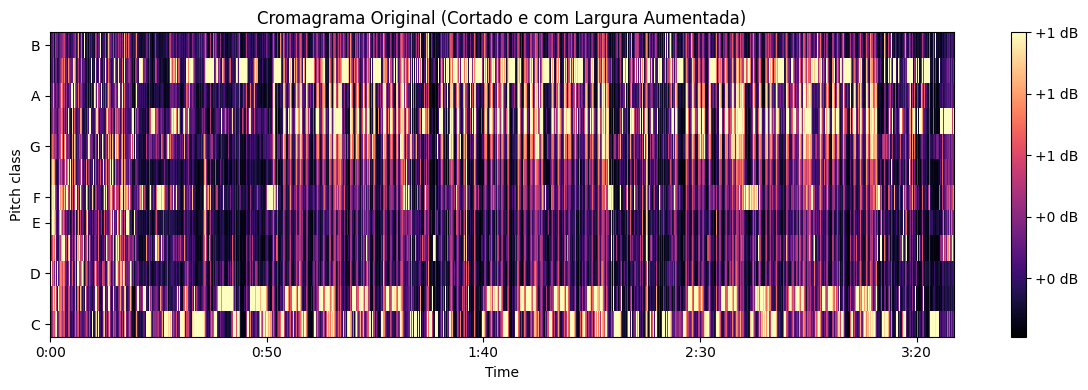

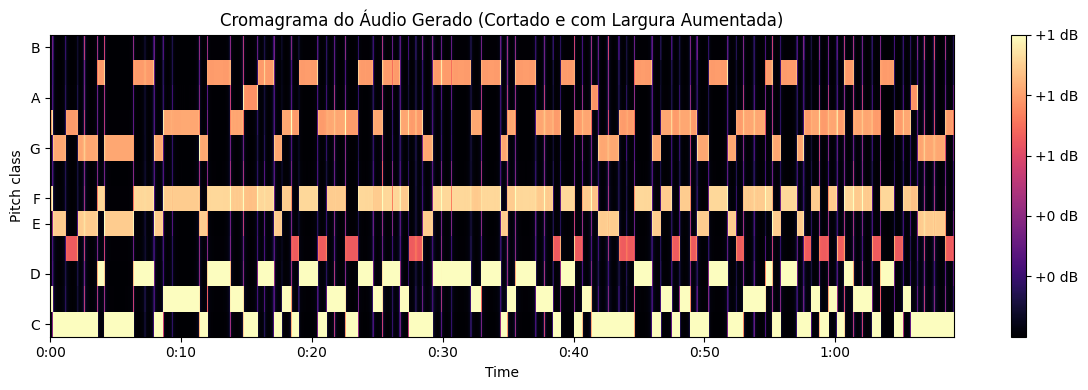

In [3]:
import sys
import librosa
sys.path.append(r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\src')
import functions as f
path_teste = r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\musics\wav\Worth_It_YK_Osiris.wav'

def extract_chroma(path):
    # Carregar o áudio
    y, sr = librosa.load(path)
    # Extrair o cromagrama
    return librosa.feature.chroma_cqt(y=y, sr=sr)

chromas = extract_chroma(path_teste)
notes = f.chroma_to_notes(chromas, min_duration=0.5)
output_audio = f.transform_chords_to_piano(notes)

f.plot_chromagrams_for_evaluation(path_teste, output_audio)

In [ ]:
chromas[:, 0:60]
sr=22050, hop_length=512

librosa.display.specshow(
    chromas,
    y_axis="chroma",
    x_axis="time",
    sr=sr,
    hop_length=hop_length,
)
plt.colorbar(format="%+2.0f dB")
plt.title("Cromagrama do Áudio Gerado (Cortado e com Largura Aumentada)")
plt.tight_layout()
plt.show()

array([[0.2874568 , 0.21171792, 0.18440244, 0.1482351 , 0.1158784 ,
        0.09151243, 0.07523777, 0.06290015, 0.05903246, 0.05927239,
        0.05909376, 0.05681106, 0.05792657, 0.06509303, 0.07361023,
        0.08274679, 0.09128125, 0.09856099, 0.10463969, 0.10951594,
        0.1170723 , 0.12963156, 0.15013371, 0.18128163, 0.22705595,
        0.2853182 , 0.36156145, 0.44607434, 0.46826512, 0.5185828 ,
        0.50985783, 0.5045019 , 0.5231274 , 0.36519173, 0.33001807,
        0.24766916, 0.25526744, 0.19554111, 0.34518358, 0.587382  ,
        0.57913923, 0.5916988 , 0.5610086 , 0.56939703, 0.45566106,
        0.40862527, 0.31397846, 0.38176948, 0.50521034, 0.56368005,
        0.57219446, 0.6474473 , 0.68788755, 0.7290818 , 0.6595141 ,
        0.64425397, 0.61628425, 0.601926  , 0.59967446, 0.6018994 ],
       [0.66186166, 0.6368349 , 0.5552417 , 0.44209185, 0.3471061 ,
        0.2713223 , 0.21458673, 0.1576259 , 0.1136803 , 0.089144  ,
        0.07357319, 0.0658176 , 0.06672648, 0.0

C:\Users\Xonas\AppData\Local\Temp\ipykernel_6280\254917810.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


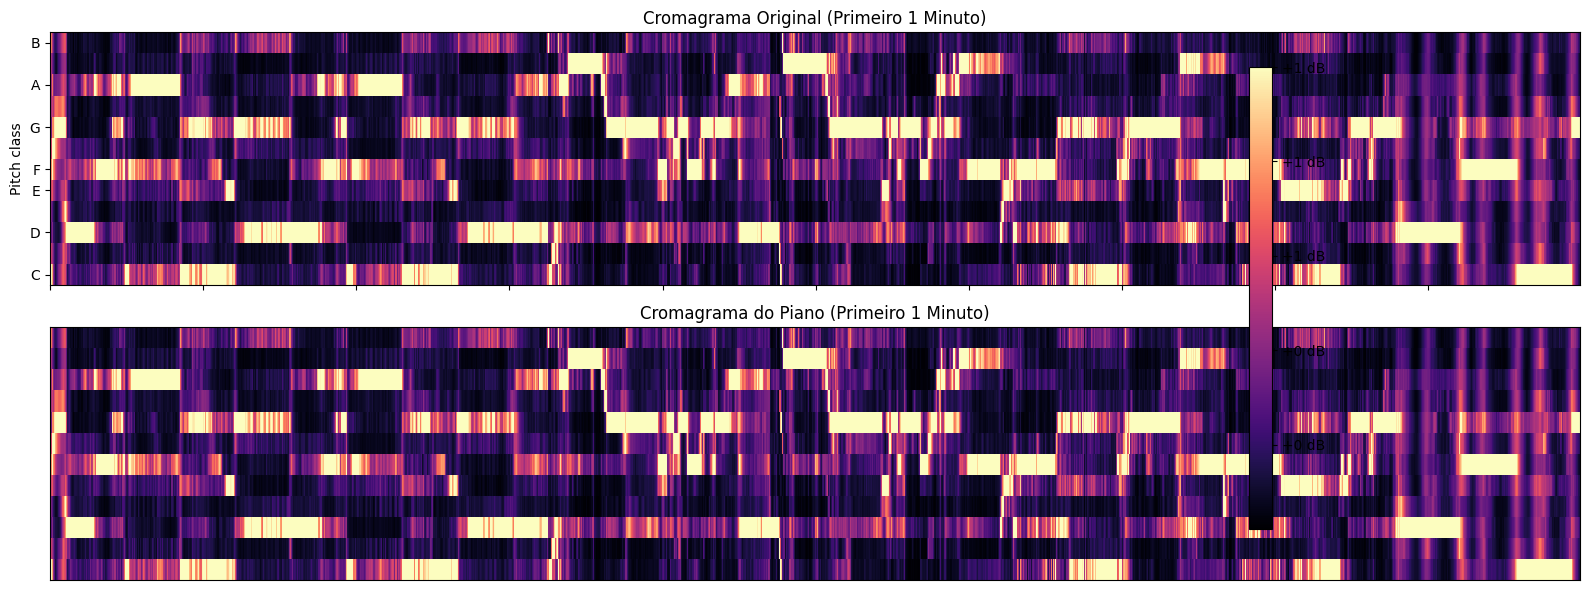

In [141]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def extract_chroma(path):
    y, sr = librosa.load(path)
    return librosa.feature.chroma_cqt(y=y, sr=sr)

# Supondo que 'chroma_data' (original) já esteja carregado
original_chroma = chroma_data
sr_original = 22050  # Ajuste se necessário

# Supondo que 'piano_music.wav' seja o caminho para o arquivo gerado
piano_audio_path = 'piano_music.wav'
try:
    output_chroma = extract_chroma(piano_audio_path)
    sr_output = librosa.get_samplerate(piano_audio_path)
except Exception as e:
    print(f"Erro ao carregar ou extrair chroma do arquivo '{piano_audio_path}': {e}")
    output_chroma = None
    sr_output = None

if output_chroma is not None:
    # --- Ajustes para a visualização ---
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))  # 1 linha, 2 colunas

    duration_to_cut = 60  # 1 minuto em segundos
    hop_length = 512  # Assumindo hop_length padrão

    # --- Plot do cromagrama original ---
    n_frames_original = librosa.time_to_frames(duration_to_cut, sr=sr_original, hop_length=hop_length)
    cropped_original_chroma = original_chroma[:, :n_frames_original]
    librosa.display.specshow(cropped_original_chroma, y_axis='chroma', x_axis='time', ax=axes[0])
    axes[0].set(title='Cromagrama Original (Primeiro 1 Minuto)')
    axes[0].label_outer()

    # --- Plot do cromagrama do piano ---
    if sr_output is not None:
        n_frames_output = librosa.time_to_frames(duration_to_cut, sr=sr_output, hop_length=hop_length)
        cropped_output_chroma = output_chroma[:, :n_frames_output]
        librosa.display.specshow(cropped_output_chroma, y_axis='chroma', x_axis='time', ax=axes[1])
        axes[1].set(title='Cromagrama do Piano (Primeiro 1 Minuto)')
        axes[1].label_outer()

    fig.colorbar(librosa.display.specshow(cropped_original_chroma, sr=sr_original, hop_length=hop_length), ax=axes, format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

else:
    print("Não foi possível plotar o cromagrama do piano.")

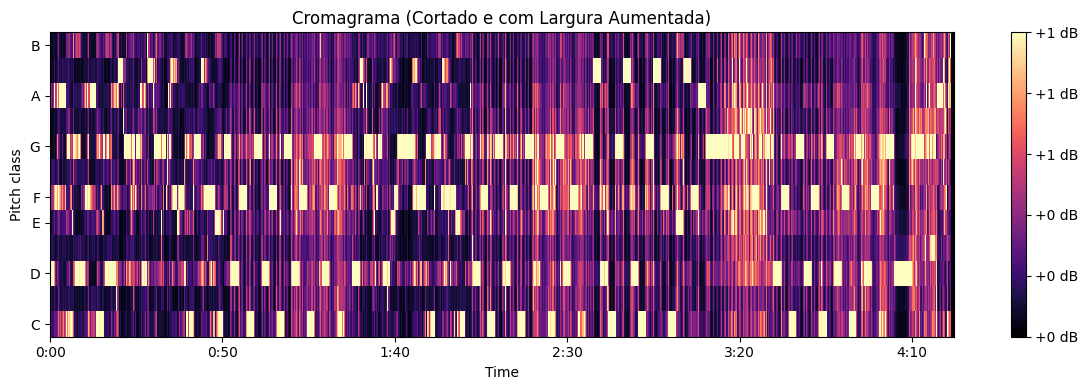

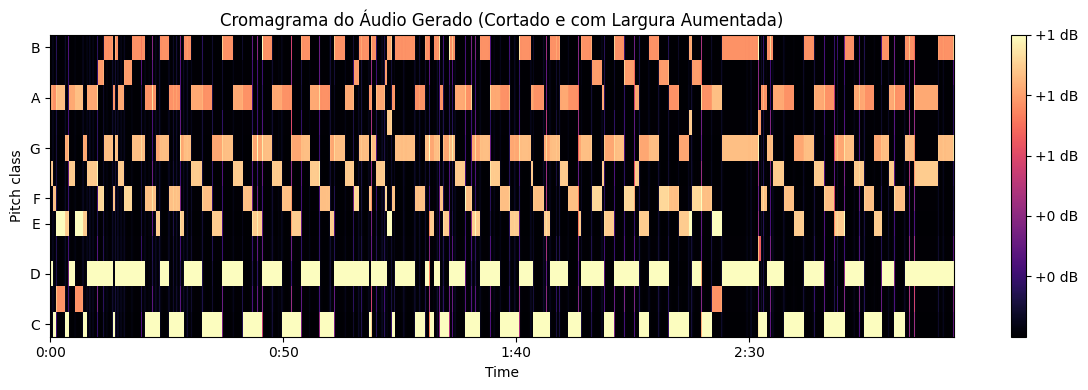

In [144]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def extract_chroma(path):
    y, sr = librosa.load(path)
    return librosa.feature.chroma_cqt(y=y, sr=sr)

# Supondo que 'chroma_data' já esteja carregado
original_chroma = chroma_data

# Supondo que 'piano_music.wav' seja o caminho para o arquivo que você quer comparar
# output_chroma = extract_chroma(r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\notebooks\piano_music.wav')

# --- Ajustes para a visualização ---
plt.figure(figsize=(12, 4))  # Aumenta a largura da imagem (width=12)

# --- Corte no chroma ---
# Vamos cortar os primeiros e os últimos 'n' quadros para focar em uma seção
n_cut_frames = 20  # Ajuste este valor conforme necessário
cropped_chroma = original_chroma[:, n_cut_frames:-n_cut_frames]

librosa.display.specshow(cropped_chroma, y_axis='chroma', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Cromagrama (Cortado e com Largura Aumentada)')
plt.tight_layout()
plt.show()

# Se você quiser visualizar o 'output_chroma' também:
plt.figure(figsize=(12, 4))
librosa.display.specshow(output_chroma[:, n_cut_frames:-n_cut_frames], y_axis='chroma', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Cromagrama do Áudio Gerado (Cortado e com Largura Aumentada)')
plt.tight_layout()
plt.show()

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def extract_chroma(path):
    y, sr = librosa.load(path)
    return librosa.feature.chroma_cqt(y=y, sr=sr)

# Supondo que 'chroma_data' já esteja carregado
original_chroma = chroma_data
sr_original = 22050  # Ajuste se necessário

# Supondo que 'piano_music.wav' seja o caminho para o arquivo gerado
piano_audio_path = 'piano_music.wav'
try:
    output_chroma = extract_chroma(piano_audio_path)
    sr_output = librosa.get_samplerate(piano_audio_path)
except Exception as e:
    print(f"Erro ao carregar ou extrair chroma do arquivo '{piano_audio_path}': {e}")
    output_chroma = None
    sr_output = None

# --- Ajustes para a visualização em subplots ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))  # 2 linhas, 1 coluna

duration_to_cut = 20  # 1 minuto em segundos
hop_length = 512  # Assumindo hop_length padrão

# --- Plot do cromagrama original (subplot [0]) ---
n_frames_original = librosa.time_to_frames(duration_to_cut, sr=sr_original, hop_length=hop_length)
cropped_original_chroma = original_chroma[:, :n_frames_original]
img_orig = librosa.display.specshow(cropped_original_chroma, y_axis='chroma', x_axis='time', ax=axes[0])
axes[0].set(title='Cromagrama Original (Primeiro 1 Minuto)')
axes[0].label_outer()

# --- Plot do cromagrama do piano (subplot [1]) ---
if output_chroma is not None and sr_output is not None:
    n_frames_output = librosa.time_to_frames(duration_to_cut, sr=sr_output, hop_length=hop_length)
    cropped_output_chroma = output_chroma[:, :n_frames_output]
    img_piano = librosa.display.specshow(cropped_output_chroma, y_axis='chroma', x_axis='time', ax=axes[1])
    axes[1].set(title='Cromagrama do Piano (Primeiro 1 Minuto)')
    axes[1].label_outer()
elif output_chroma is None:
    axes[1].set(title='Cromagrama do Piano (Não Carregado)')

# Adiciona a barra de cores a um eixo separado para controle do posicionamento
fig.colorbar(img_orig, ax=axes, format='%+2.0f dB', location='right', shrink=0.8)

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta o layout para dar espaço à barra de cores
plt.show()

NameError: name 'chroma_data' is not defined

In [149]:
import librosa
import numpy as np
from sklearn.metrics import accuracy_score

def extract_chroma_and_simplify(audio_path, sr=22050, hop_length=512, min_duration=0.2, threshold=0.8):
    """
    Extrai o cromagrama, simplifica e concatena acordes.
    Retorna uma sequência de (chord, start_time_sec, end_time_sec).
    """
    y, sr = librosa.load(audio_path, sr=sr)
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)

    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    num_frames = chromagram.shape[1]
    raw_chords = []
    current_chord = None
    current_start_time = 0.0

    def get_chord_from_chroma(chroma_vector, threshold=threshold):
        max_val = np.max(chroma_vector)
        if max_val > threshold:
            max_index = np.argmax(chroma_vector)
            return notes[max_index]
        return None

    for i in range(num_frames):
        time_sec = librosa.frames_to_time(i, sr=sr, hop_length=hop_length)
        chord = get_chord_from_chroma(chromagram[:, i])
        if chord != current_chord:
            if current_chord is not None:
                raw_chords.append((current_chord, current_start_time, time_sec))
            current_chord = chord
            current_start_time = time_sec
    if current_chord is not None:
        raw_chords.append((current_chord, current_start_time, librosa.frames_to_time(num_frames, sr=sr, hop_length=hop_length)))

    final_chords = []
    if raw_chords:
        current_final_chord = raw_chords[0][0]
        current_final_start_time = raw_chords[0][1]
        current_final_end_time = raw_chords[0][2]
        for i in range(1, len(raw_chords)):
            chord, start_time, end_time = raw_chords[i]
            if chord == current_final_chord:
                current_final_end_time = end_time
            else:
                duration = current_final_end_time - current_final_start_time
                if duration >= min_duration:
                    final_chords.append((current_final_chord, current_final_start_time, current_final_end_time))
                current_final_chord = chord
                current_final_start_time = start_time
                current_final_end_time = end_time
        duration = current_final_end_time - current_final_start_time
        if duration >= min_duration:
            final_chords.append((current_final_chord, current_final_start_time, current_final_end_time))

    return final_chords

def evaluate_chord_extraction(original_audio_path, generated_audio_path, sr=22050, hop_length=512, frame_rate=10):
    """
    Avalia a extração de acordes comparando as sequências do áudio original
    e do áudio gerado, discretizando o tempo.

    Args:
        original_audio_path (str): Caminho para o arquivo de áudio original.
        generated_audio_path (str): Caminho para o arquivo de áudio gerado (piano).
        sr (int): Taxa de amostragem.
        hop_length (int): Tamanho do hop para análise.
        frame_rate (float): Taxa de amostragem para discretizar a sequência de acordes (Hz).

    Returns:
        float: A acurácia da correspondência dos acordes ao longo do tempo.
               Retorna None se não for possível extrair acordes de algum arquivo.
    """
    original_chords = extract_chroma_and_simplify(original_audio_path, sr=sr, hop_length=hop_length)
    generated_chords = extract_chroma_and_simplify(generated_audio_path, sr=sr, hop_length=hop_length)

    if not original_chords or not generated_chords:
        print("Não foi possível extrair sequências de acordes de um ou ambos os arquivos.")
        return None

    def discretize_chords(chord_sequence, total_duration, frame_rate):
        """Discretiza a sequência de acordes em intervalos de tempo fixos."""
        time_points = np.arange(0, total_duration, 1 / frame_rate)
        discretized = []
        for t in time_points:
            current_chord = None
            for chord, start, end in chord_sequence:
                if start <= t < end:
                    current_chord = chord
                    break
            discretized.append(current_chord if current_chord else 'N') # 'N' para nenhum acorde claro
        return discretized

    # Calcular a duração total (aproximada)
    y_orig, sr_orig = librosa.load(original_audio_path, sr=sr)
    duration_orig = librosa.get_duration(y=y_orig, sr=sr_orig)

    y_gen, sr_gen = librosa.load(generated_audio_path, sr=sr)
    duration_gen = librosa.get_duration(y=y_gen, sr=sr_gen)

    total_duration = min(duration_orig, duration_gen) # Compara até a menor duração

    original_discrete = discretize_chords(original_chords, total_duration, frame_rate)
    generated_discrete = discretize_chords(generated_chords, total_duration, frame_rate)

    # Alinhar as sequências ao menor comprimento
    min_len = min(len(original_discrete), len(generated_discrete))
    original_discrete = original_discrete[:min_len]
    generated_discrete = generated_discrete[:min_len]

    if not original_discrete or not generated_discrete:
        print("Não foi possível discretizar as sequências de acordes.")
        return None

    accuracy = accuracy_score(original_discrete, generated_discrete)
    return accuracy

if __name__ == '__main__':
    original_audio = 'audio_original.wav' # Substitua pelo caminho do seu arquivo original
    generated_audio = 'piano_music.wav'   # Substitua pelo caminho do arquivo gerado pelo seu transformador

    # Criando arquivos de áudio de teste (você deve usar seus próprios arquivos)
    sr_test = 22050
    duration_test = 10
    if not os.path.exists(original_audio):
        silence = np.zeros(sr_test * duration_test)
        librosa.output.write_wav(original_audio, silence, sr_test)
        print(f"Arquivo de teste '{original_audio}' criado.")
    if not os.path.exists(generated_audio):
        freq = librosa.note_to_hz('C4')
        t = np.linspace(0, duration_test, int(sr_test * duration_test), False)
        note = 0.1 * np.sin(2 * np.pi * freq * t)
        librosa.output.write_wav(generated_audio, note, sr_test)
        print(f"Arquivo de teste '{generated_audio}' criado.")
    import os

    accuracy = evaluate_chord_extraction(original_audio, generated_audio)

    if accuracy is not None:
        print(f"Acurácia da correspondência de acordes: {accuracy:.2f}")
    else:
        print("A avaliação não pôde ser concluída.")

AttributeError: No librosa attribute output